# Transformer로 번역기 만들기 [프로젝트]

In [1]:
import tensorflow as tf
import numpy as np

import re
import sentencepiece as spm
from tqdm import tqdm
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

## Step 1. 데이터 다운로드

In [31]:
data_dir = './data/'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r", encoding="utf-8") as f: kor = f.read().splitlines()
    with open(eng_path, "r", encoding="utf-8") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))  # 중복 데이터 제거

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [32]:
def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환합니다.
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
    # 문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [33]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    temp_file = './data/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece를 이용해 
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./data/corpus_{lang}.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/corpus_{lang}.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 

True

 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: ./data/corpus_{lang}.txt
trainer_interface.cc(385) LOG(INFO) Loaded all 78968 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10661485
trainer_interface.cc(477) LOG(INFO) Done: 99.9909% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=29
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999909
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 78956 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making

In [34]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남김
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:04<00:00, 15988.20it/s]


## Step 3. 모델 설계

In [6]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [8]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [14]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Step 4. 훈련하기

In [15]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [16]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [17]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [18]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [19]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [20]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [21]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [22]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [23]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared=True
)

In [24]:
# 학습
from tqdm import tqdm_notebook 

EPOCHS = 20
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_72/1258607001.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the animals are going to because of the animals .
Input: 커피는 필요 없다.
Predicted translation: the new york is not because it is not to be a good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blasts were killed in the city of the area .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s poorest , is the most of the city s poorest .
Input: 커피는 필요 없다.
Predicted translation: it s not a little .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the death toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a great lakes .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not a way .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deadliest left .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the highest spots .
Input: 커피는 필요 없다.
Predicted translation: i don t know what i am .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine people were killed and wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in cities , they re all the city s city .
Input: 커피는 필요 없다.
Predicted translation: there s no indication of anything for anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on thursday , the dead were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens of the towns so they can reach the streets .
Input: 커피는 필요 없다.
Predicted translation: no coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three people were killed wednesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are demonstrators outside the city of defined .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary to make coffee for offering coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventh fatalities were killed thursday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is slated to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are seeing their venues for their lives .
Input: 커피는 필요 없다.
Predicted translation: no matter what was necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in his or cities , where they th name is one of the men is for a man s face .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is slated to be elected president .
Input: 시민들은 도시 속에 산다.
Predicted translation: downers see the cities of the mountain
Input: 커피는 필요 없다.
Predicted translation: no single practice of coffee forout just what was need for .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people dead were the seventh fatality .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re down in cities .
Input: 커피는 필요 없다.
Predicted translation: never asked for privacy what he should do anything wrong .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people dead were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama was a presidential hopeful from the presidential office .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the downtown town of is tens of thousands of people in the cities .
Input: 커피는 필요 없다.
Predicted translation: no coffee is part of coffee , he said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is slated to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: you are down , but down , they re going to cities in cities .
Input: 커피는 필요 없다.
Predicted translation: no coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed , police said wednesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , some of the city will look .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee , but there s a need forways dealing with coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the seventh of seven killed tuesday , the seventh of seven people tuesday , she told the seventh of seven people .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a night .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are busy going to be in the face of hostage lives .
Input: 커피는 필요 없다.
Predicted translation: no coffee is buying . coffee , an hour just green .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed , the seventh death toll camp reported saturday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: some are iranianally active in cities in europe .
Input: 커피는 필요 없다.
Predicted translation: no coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , . seven others were wounded on the seventh day of seven dead on wednesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate from illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people stay in cities
Input: 커피는 필요 없다.
Predicted translation: no coffee need for coffee , coffee is worth up .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven sri lankan government is all seven others wednesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential hopeful of a presidential running mate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are korea to stay in cities .
Input: 커피는 필요 없다.
Predicted translation: no one was necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the seventh fatality monday , she said .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate from illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: some are afraid to stay .
Input: 커피는 필요 없다.
Predicted translation: no coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the seventh fatality tuesday , she said .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate from illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead of plymouth , they actively looked over our torches in the cities .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee at coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , . seven others were wounded thursday , she said .


Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate barack obama .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


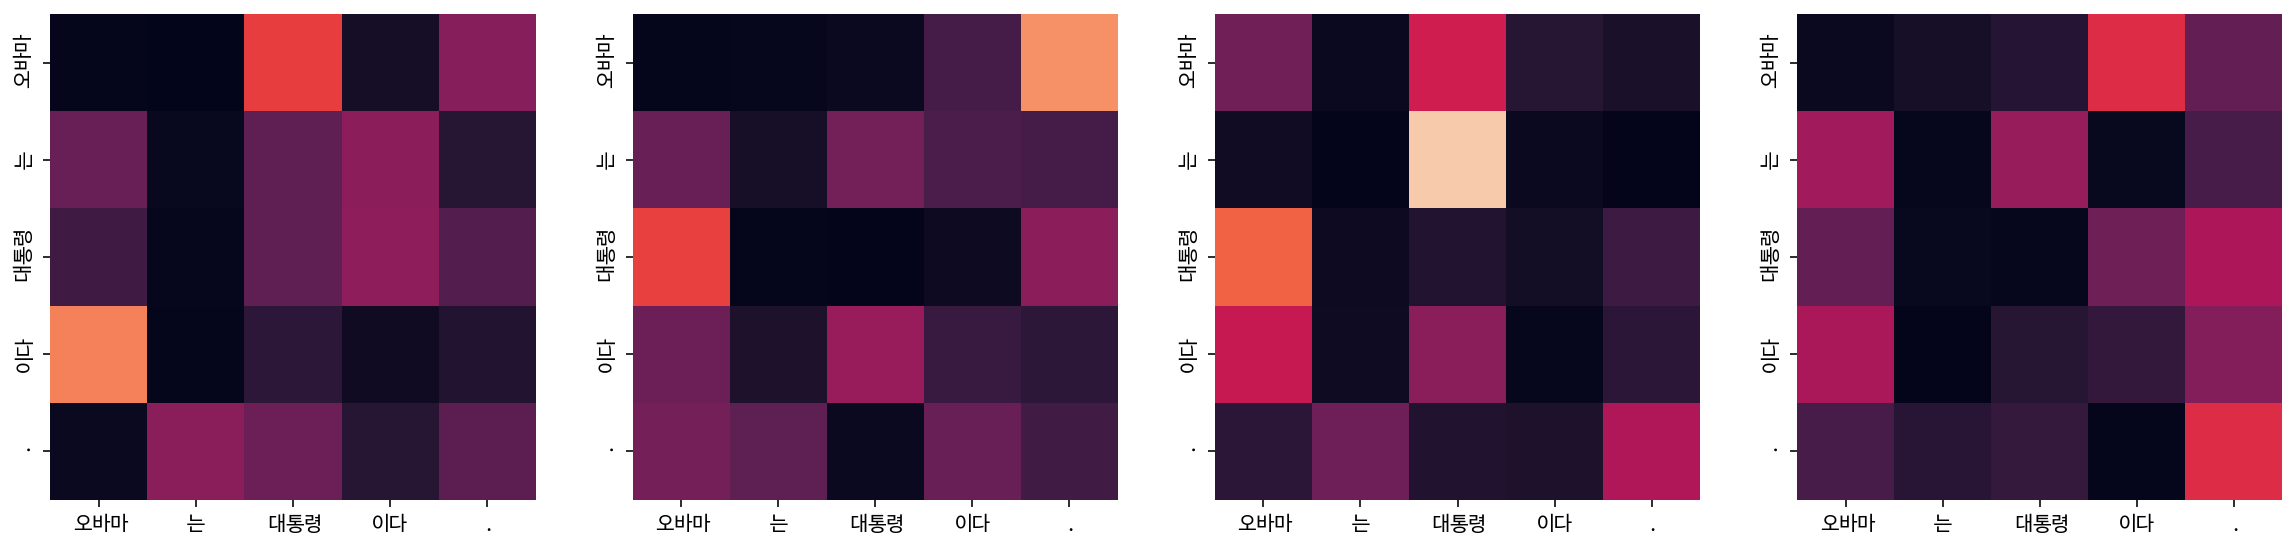

Encoder Layer 2


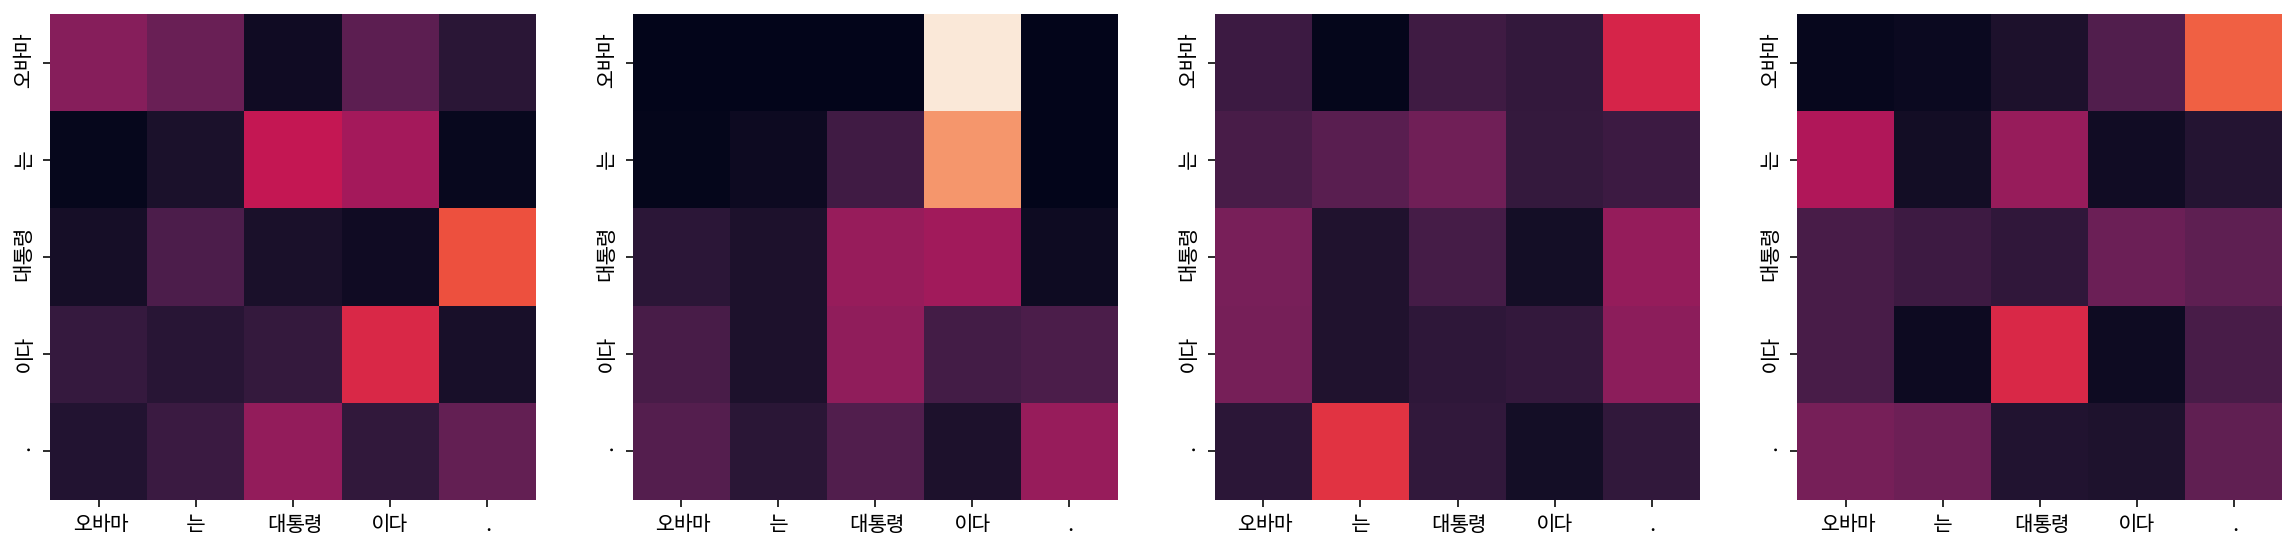

Decoder Self Layer 1


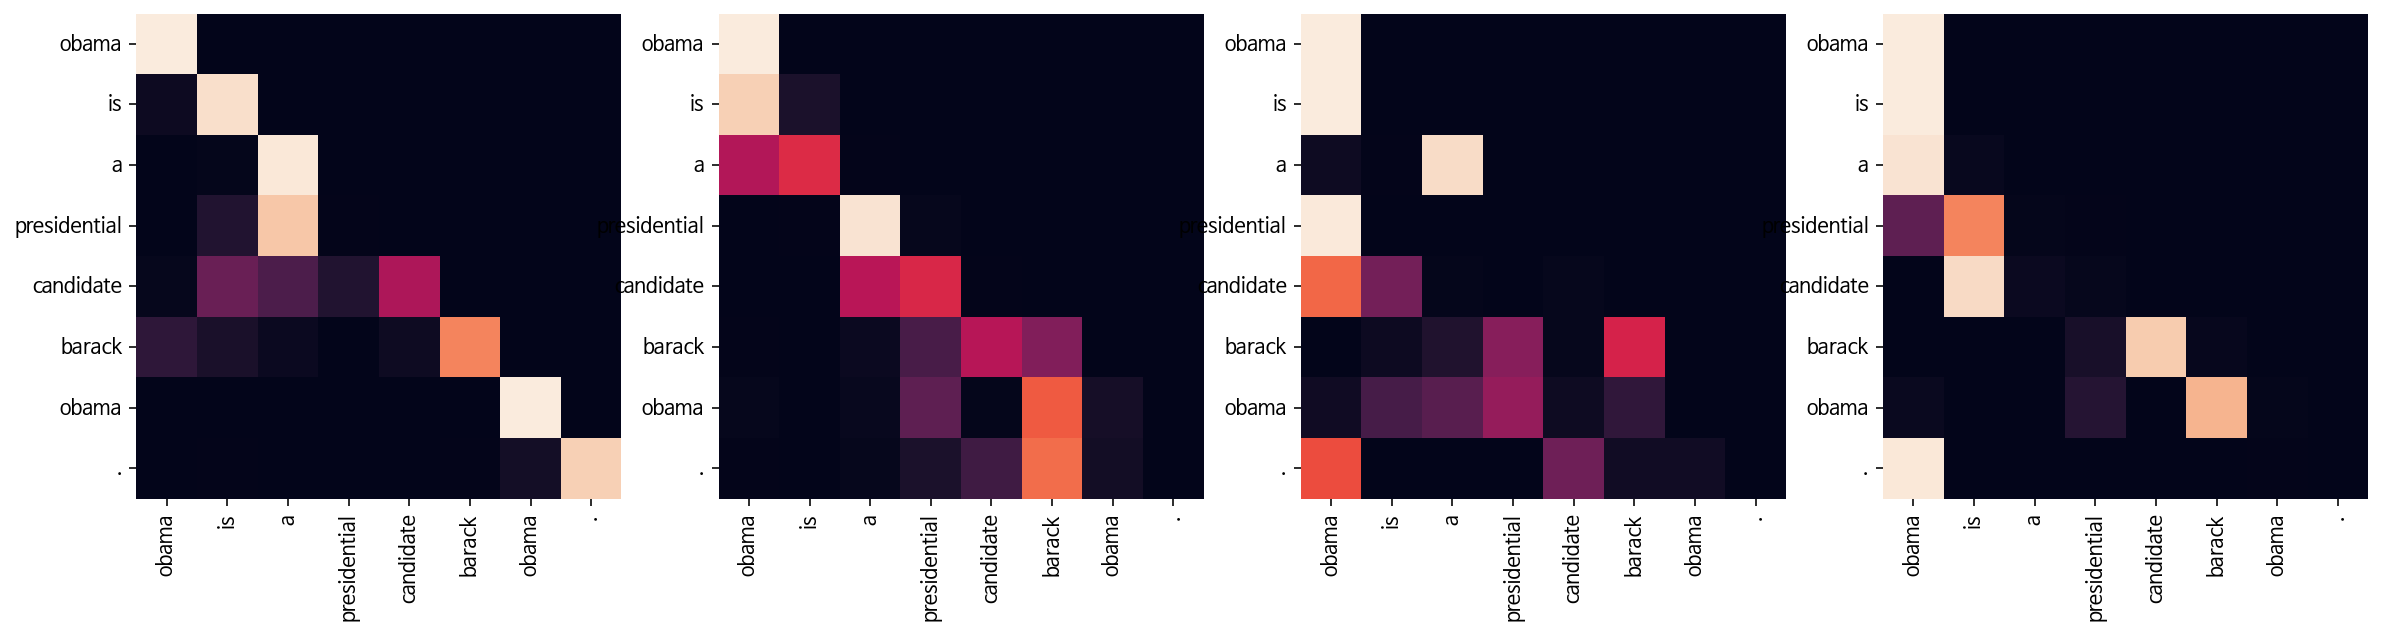

Decoder Src Layer 1


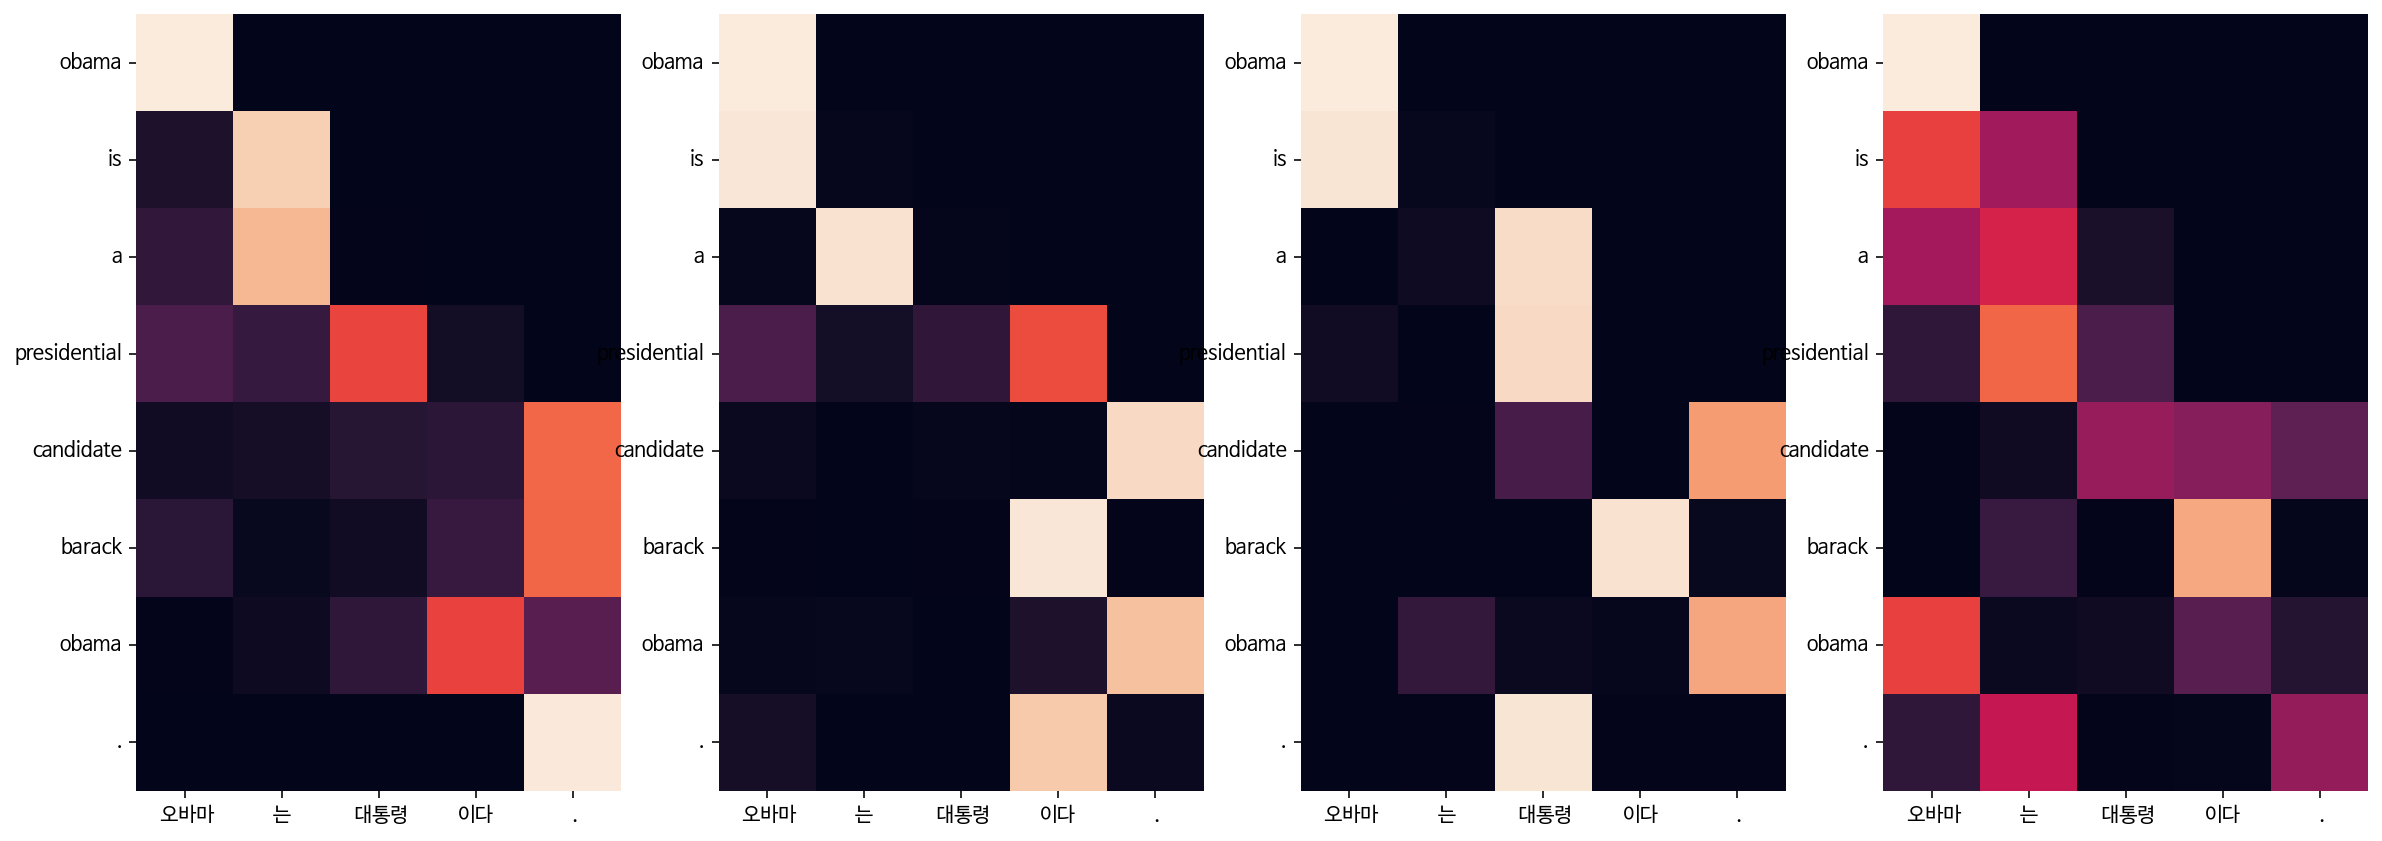

Decoder Self Layer 2


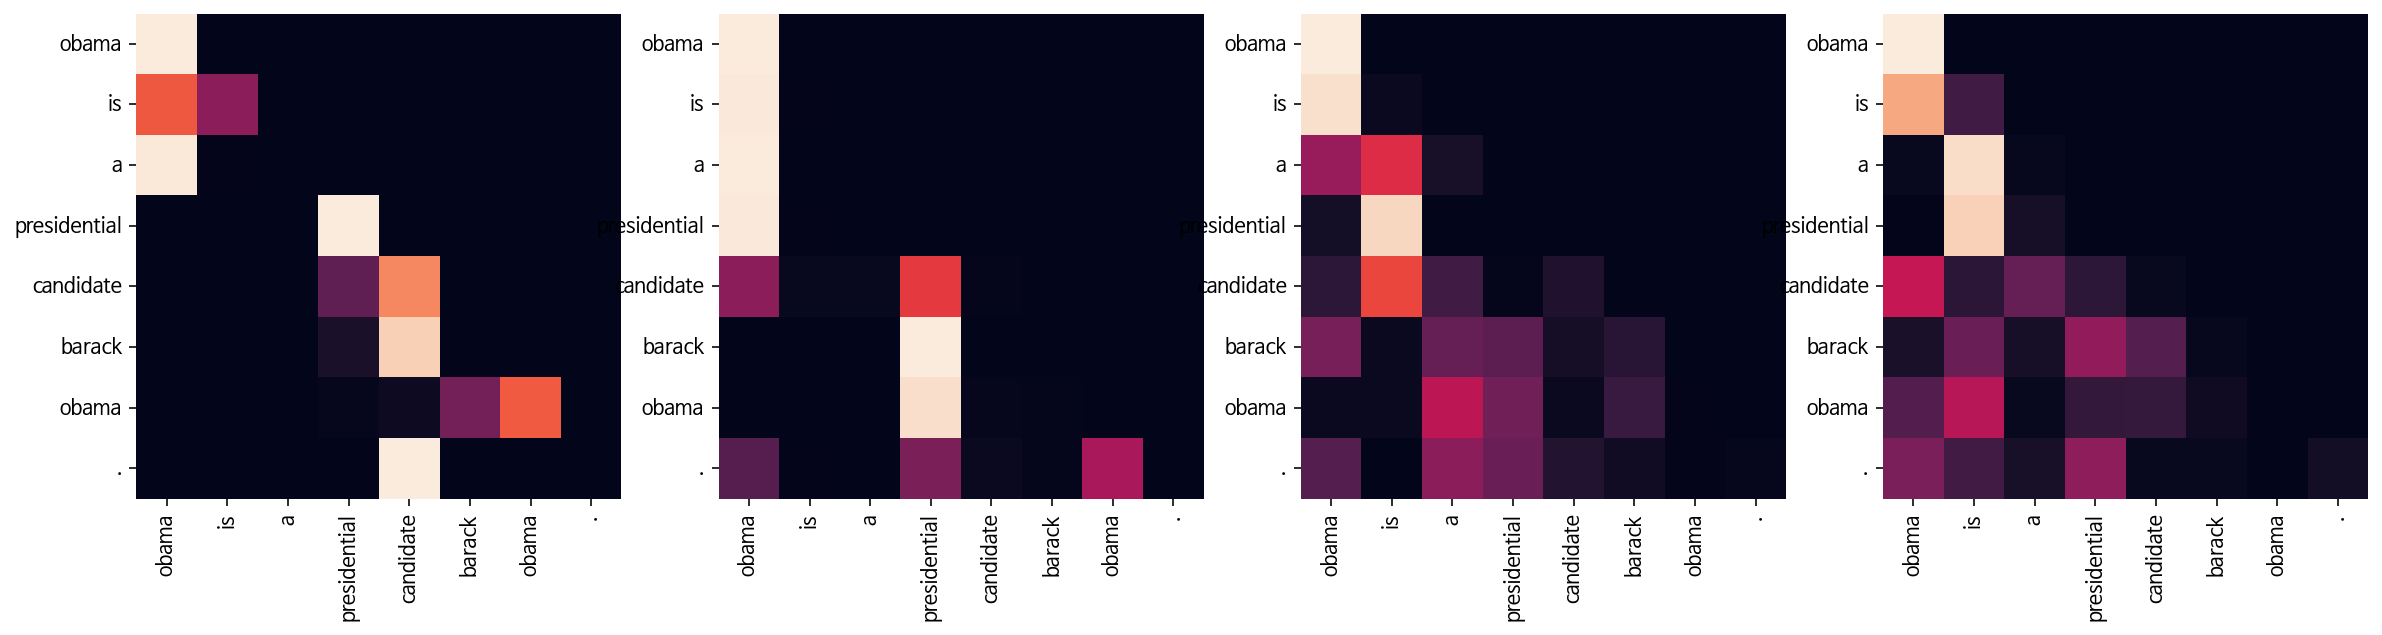

Decoder Src Layer 2


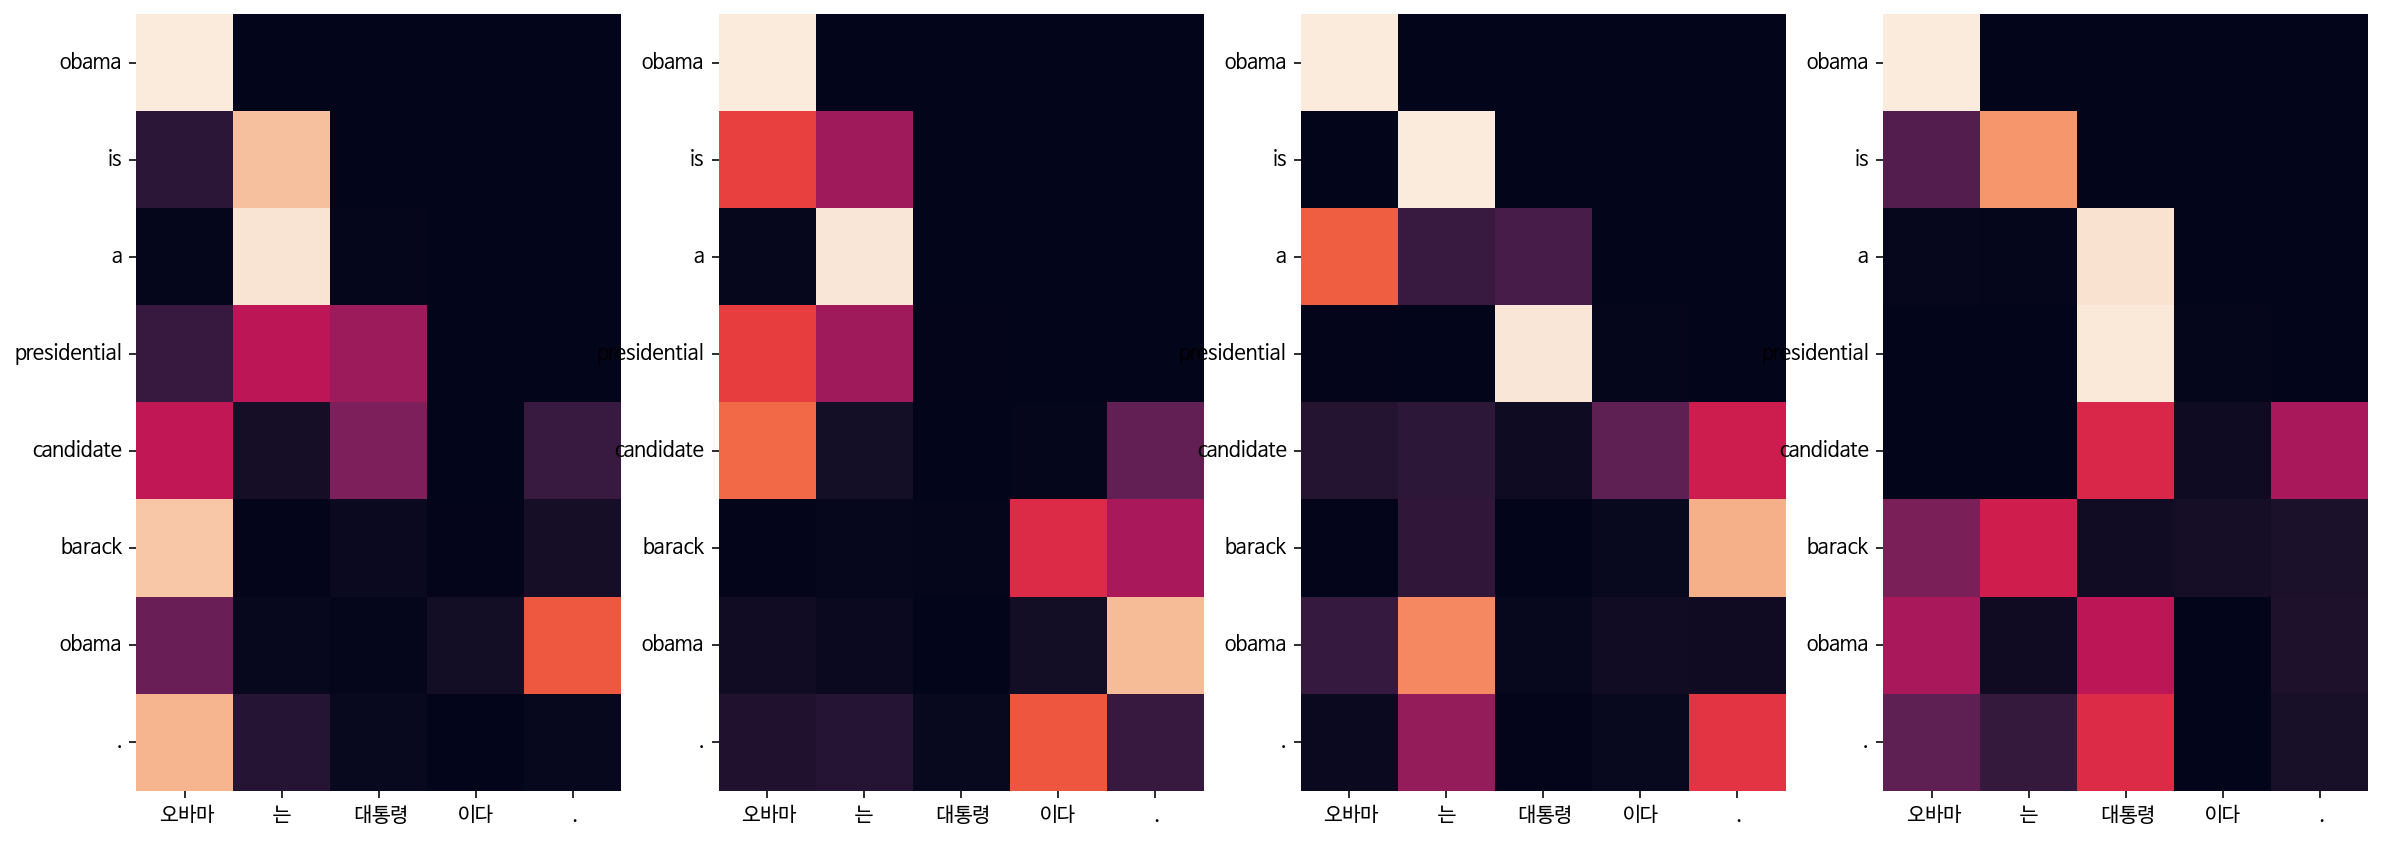

Input: 시민들은 도시 속에 산다.
Predicted translation: instead , they believe in the cities of our city .
Encoder Layer 1


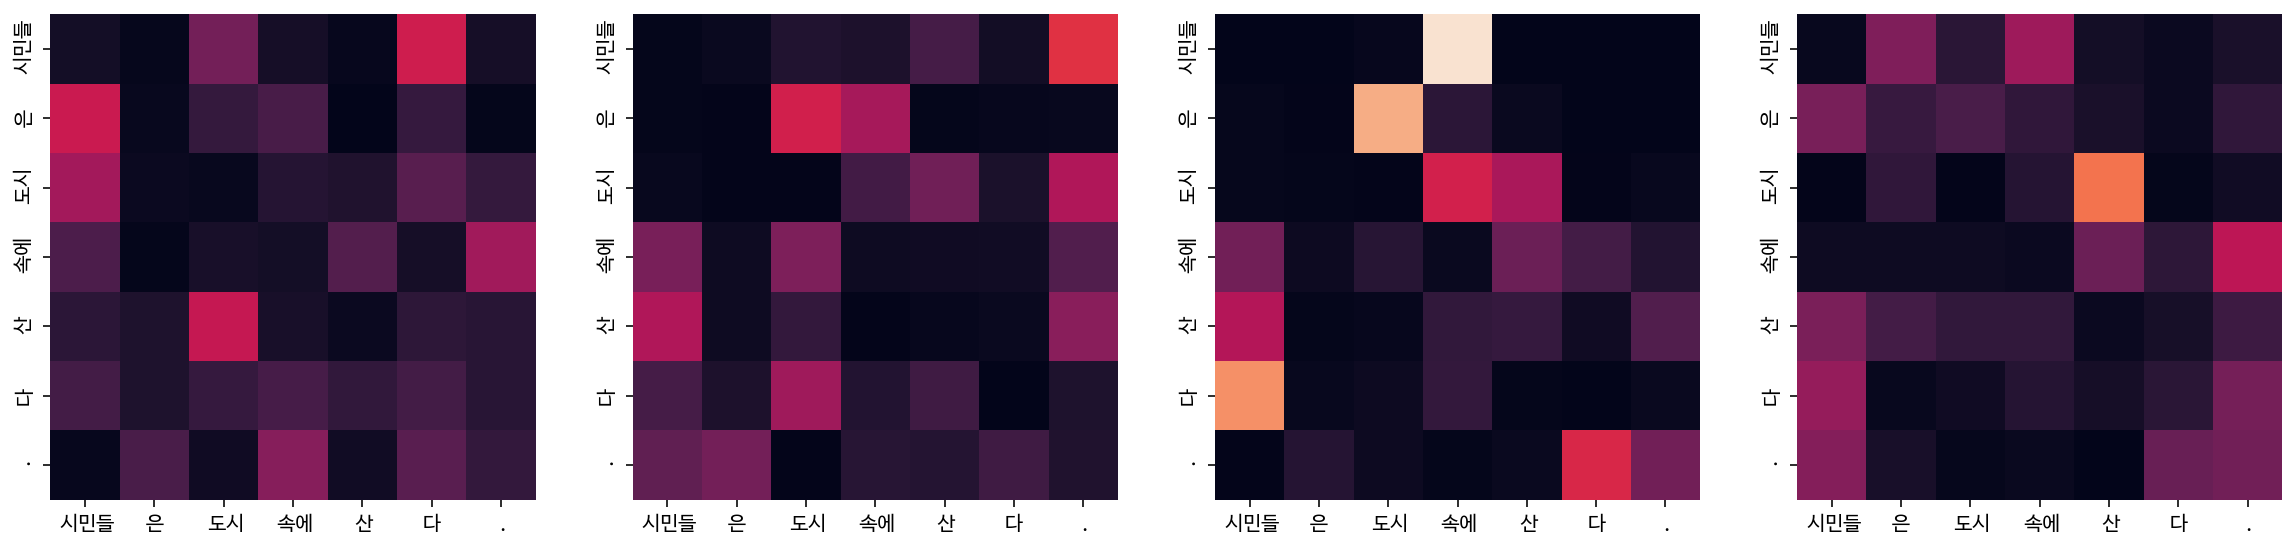

Encoder Layer 2


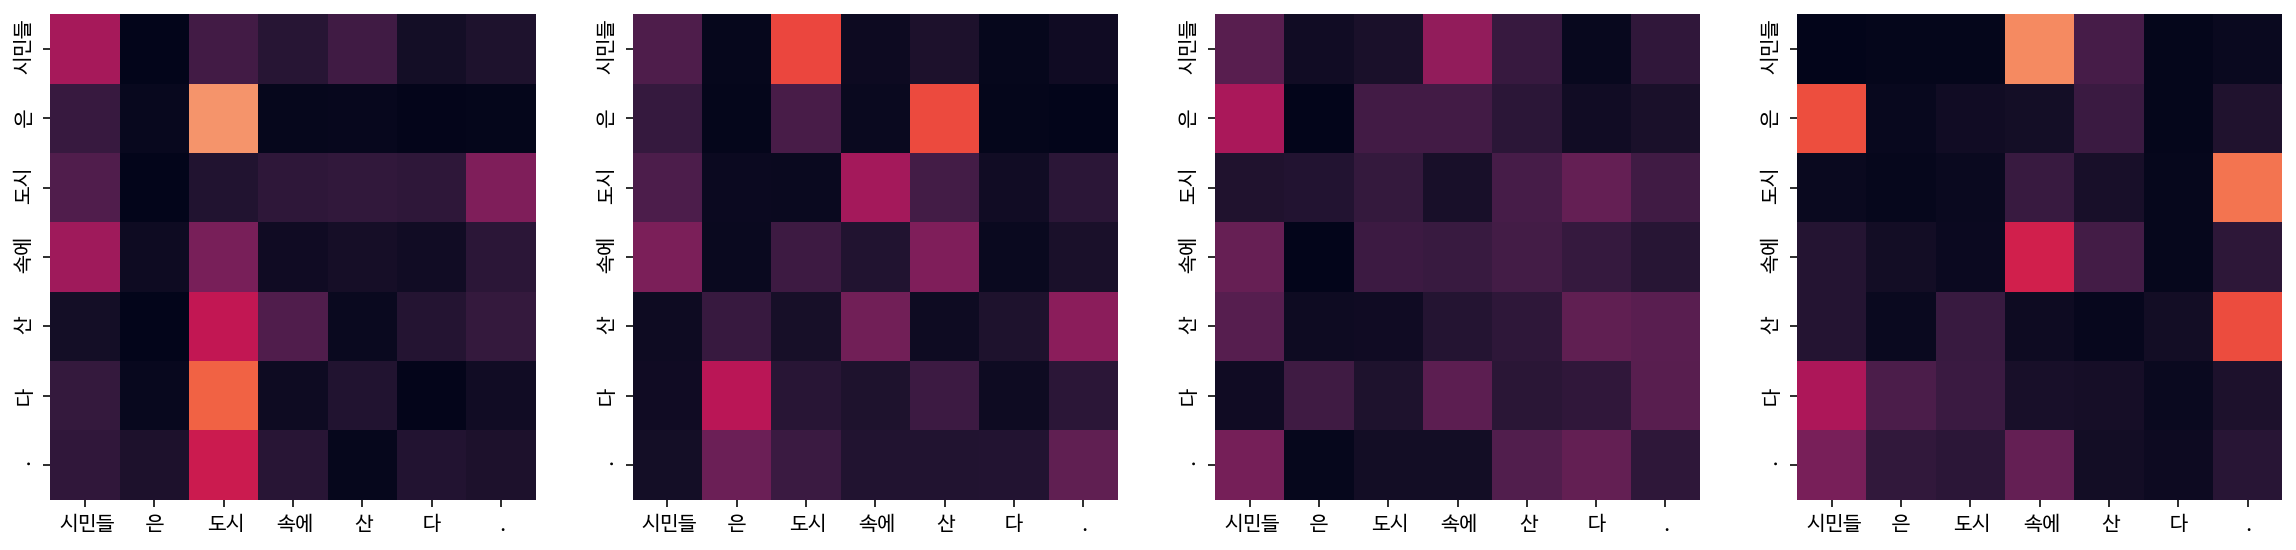

Decoder Self Layer 1


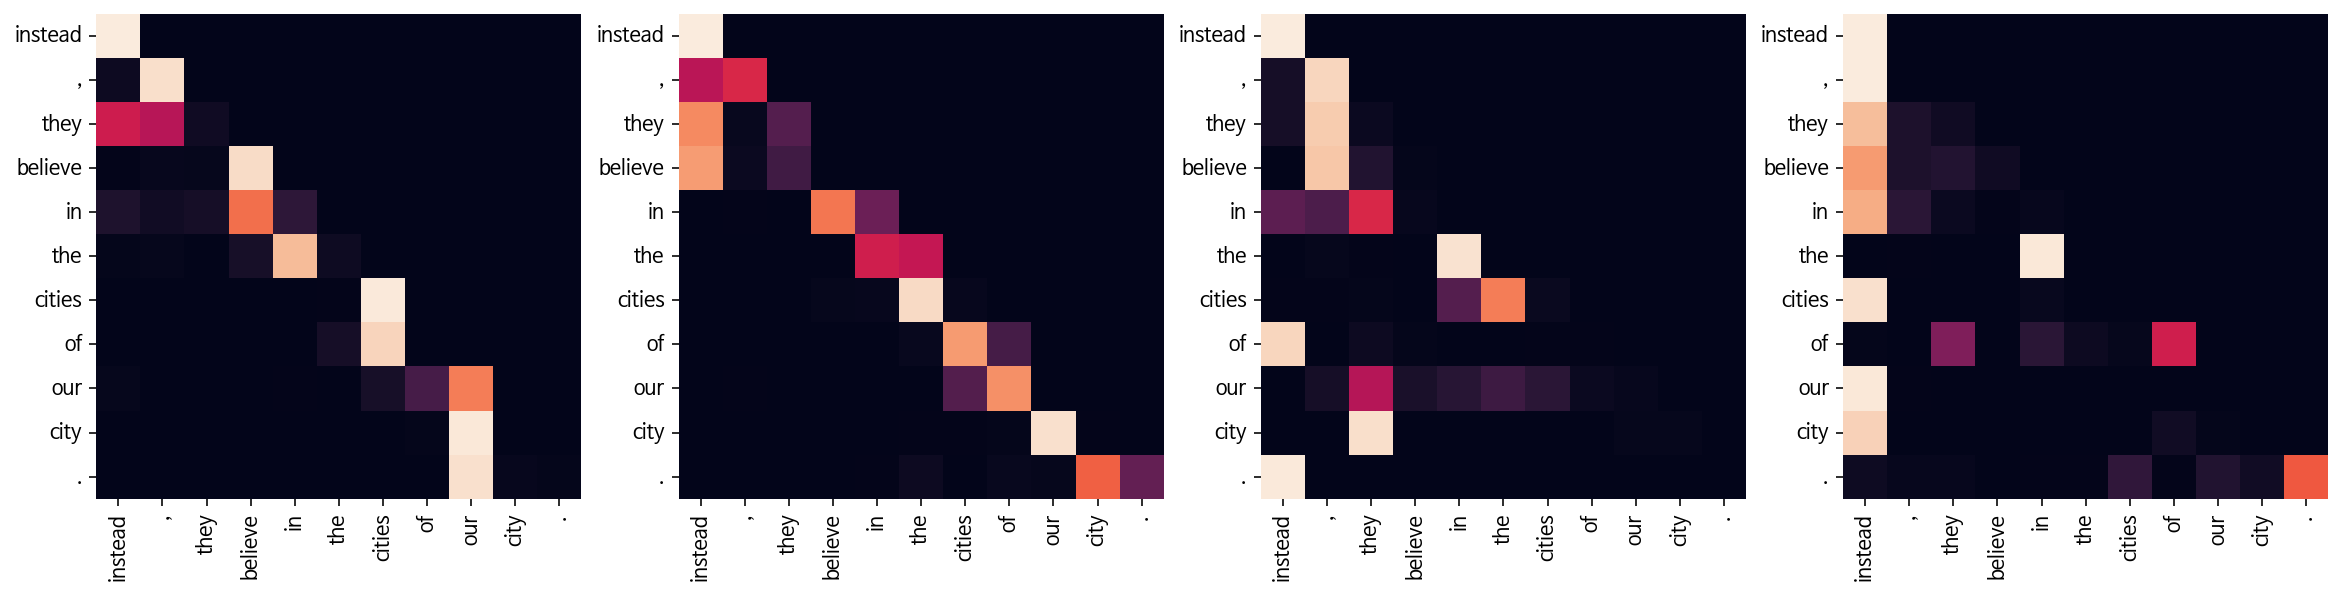

Decoder Src Layer 1


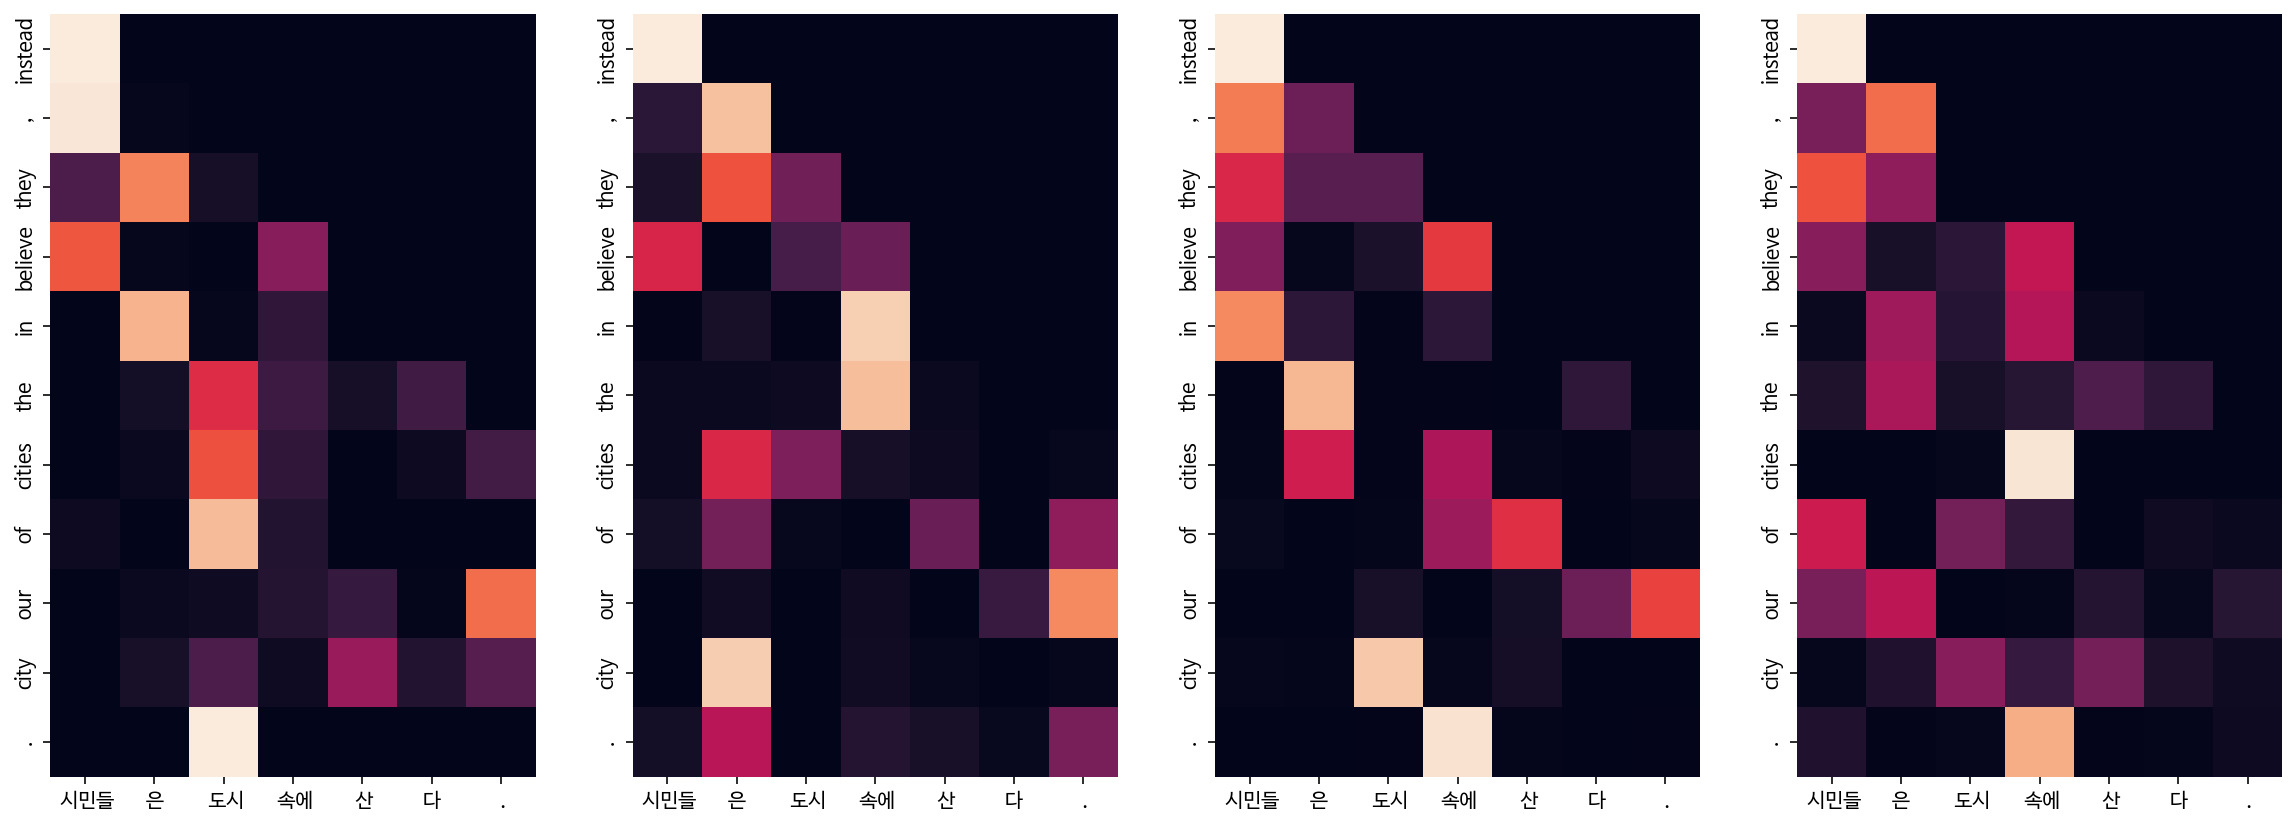

Decoder Self Layer 2


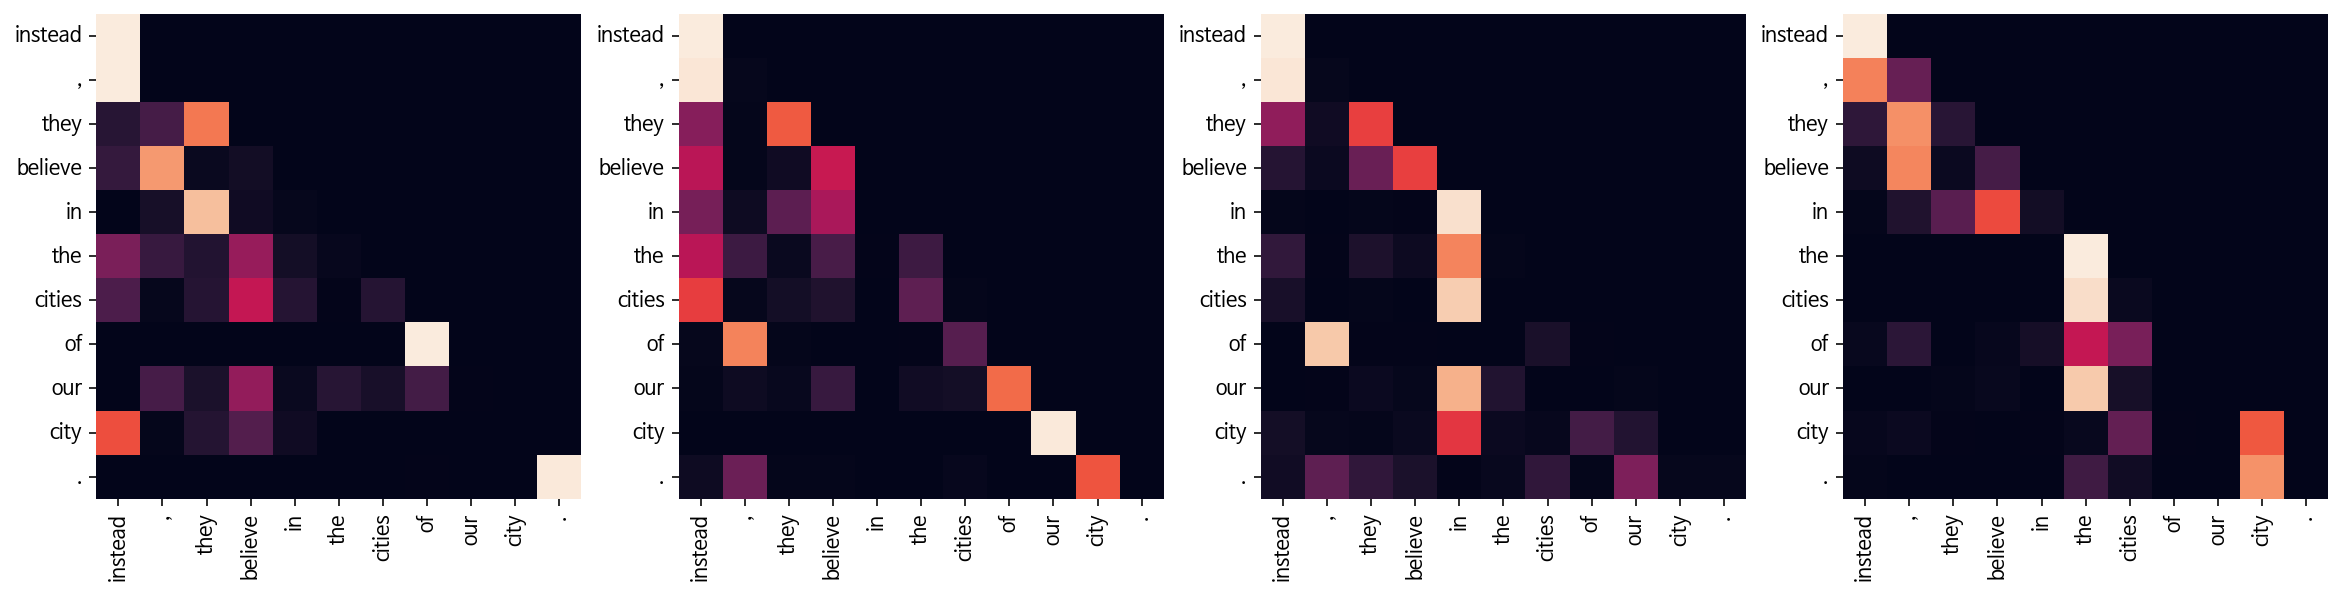

Decoder Src Layer 2


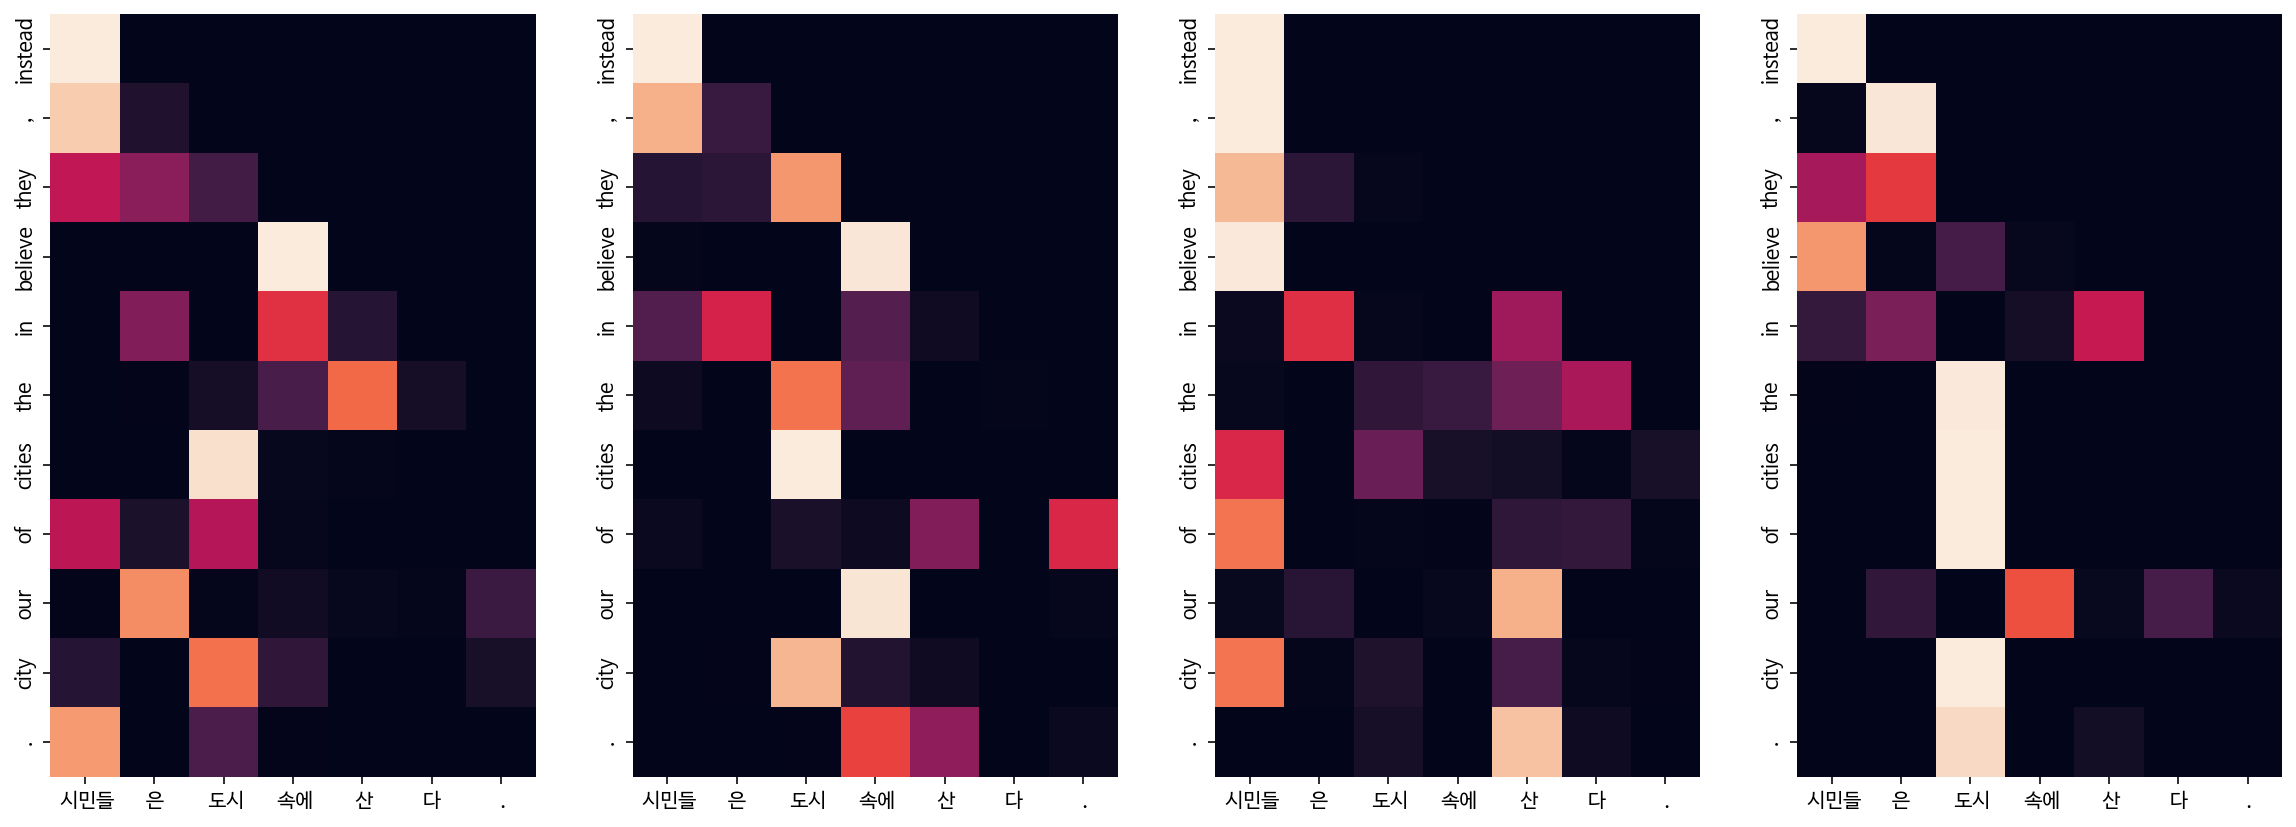

Input: 커피는 필요 없다.
Predicted translation: coffee is necessary to become a catastrophe .
Encoder Layer 1


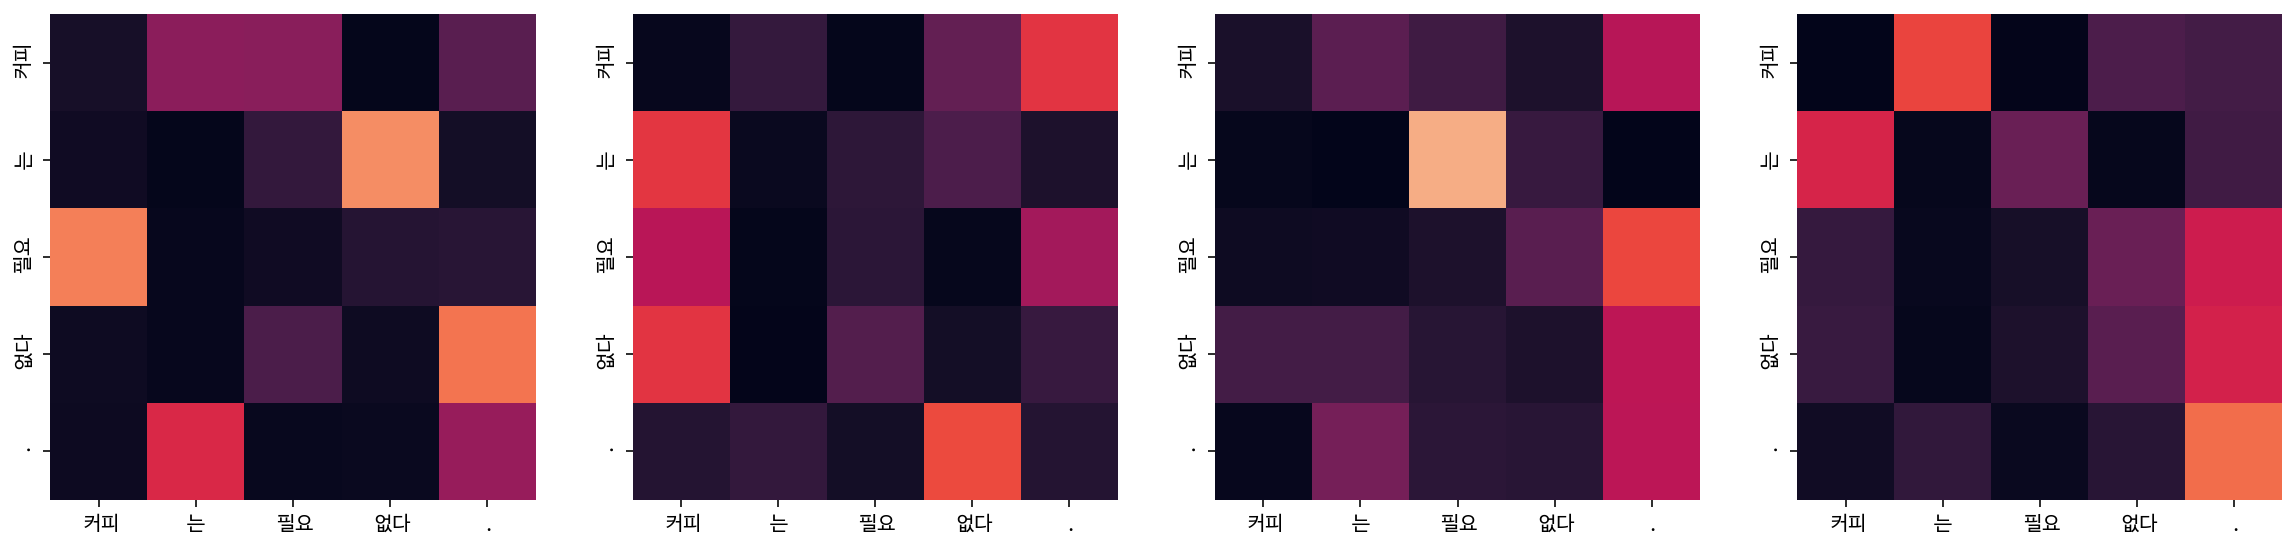

Encoder Layer 2


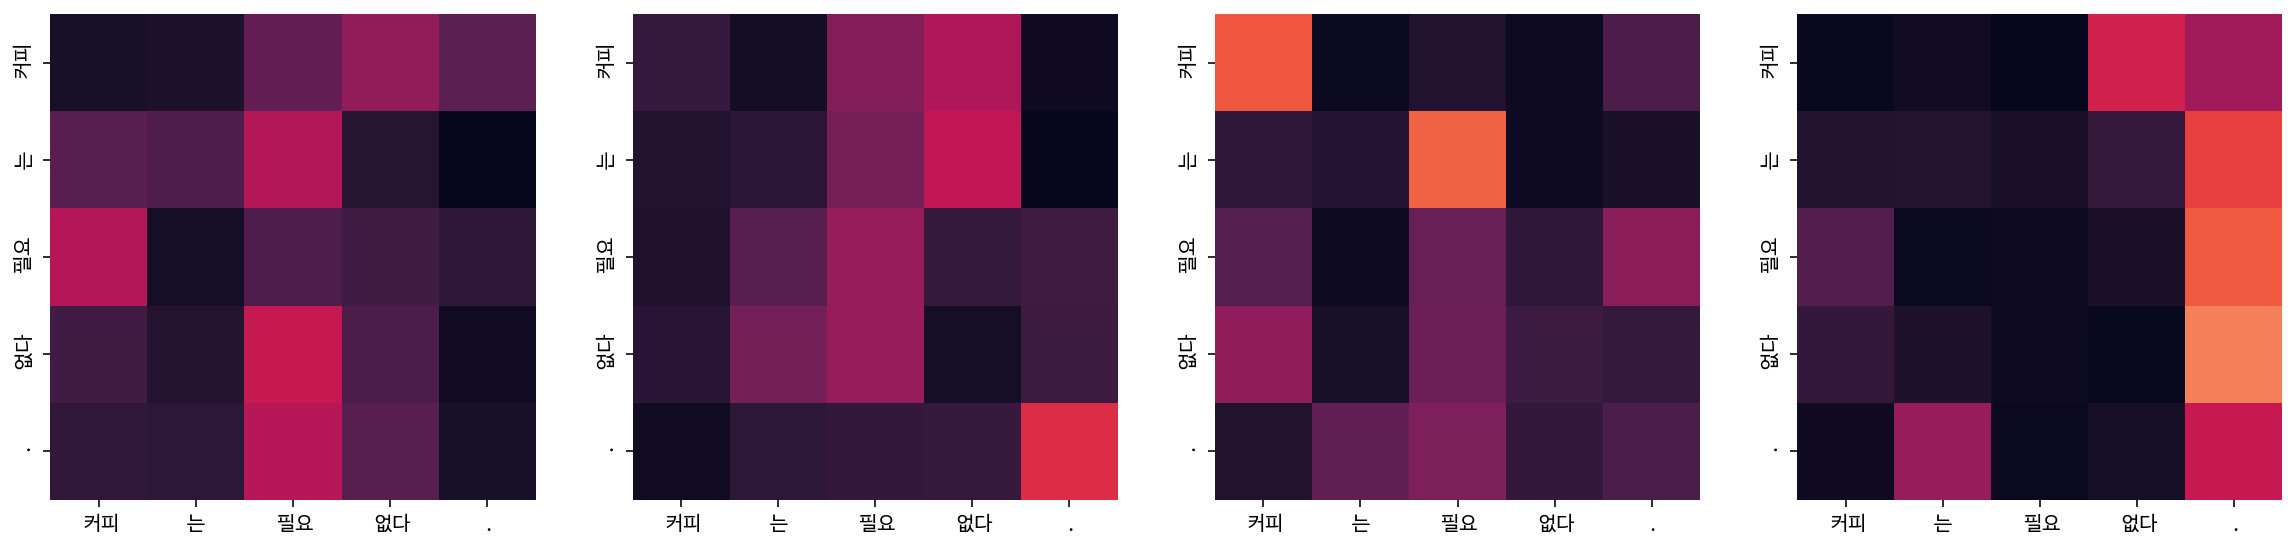

Decoder Self Layer 1


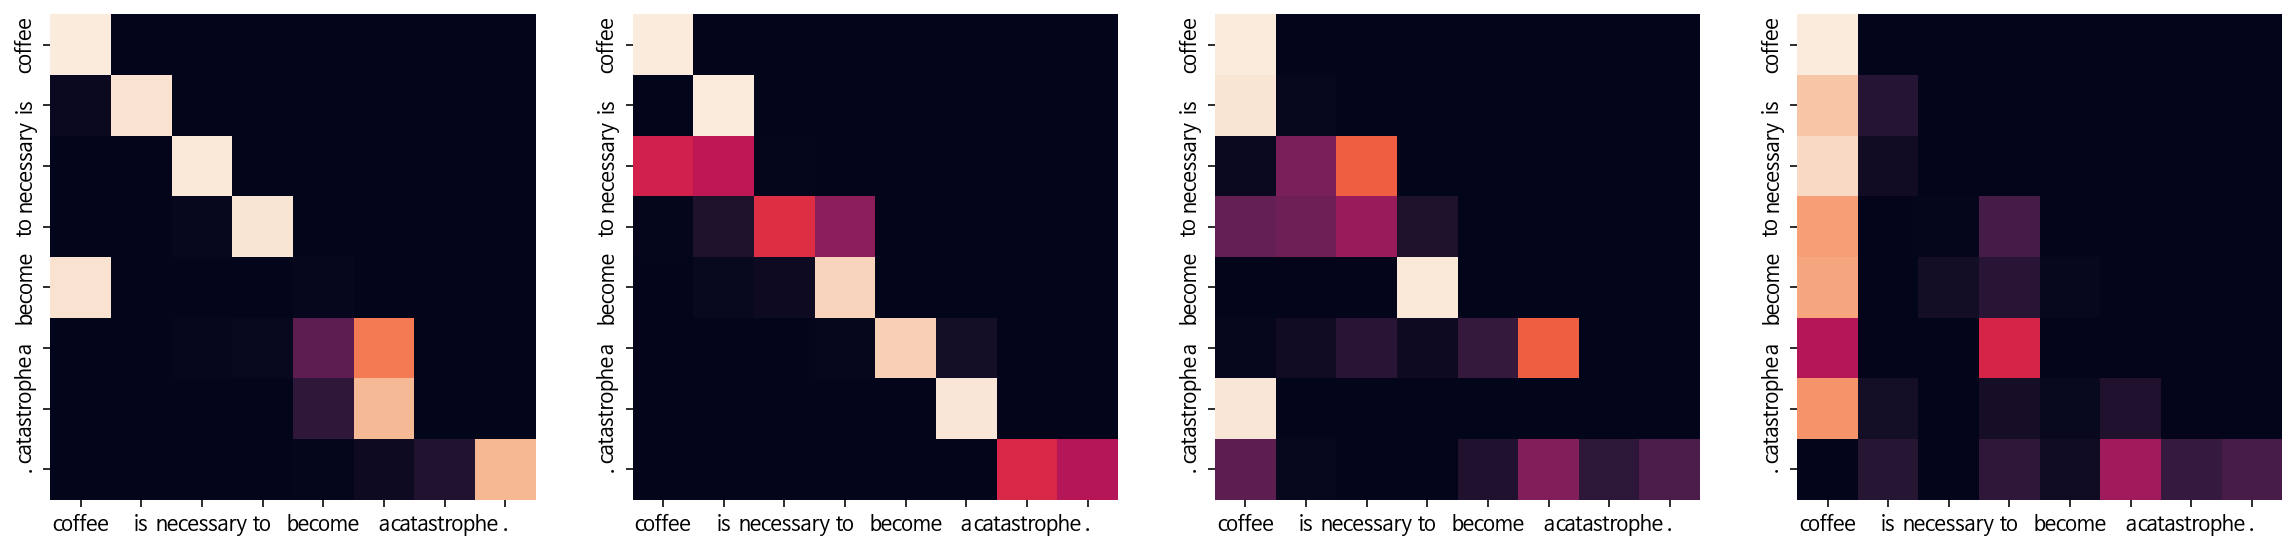

Decoder Src Layer 1


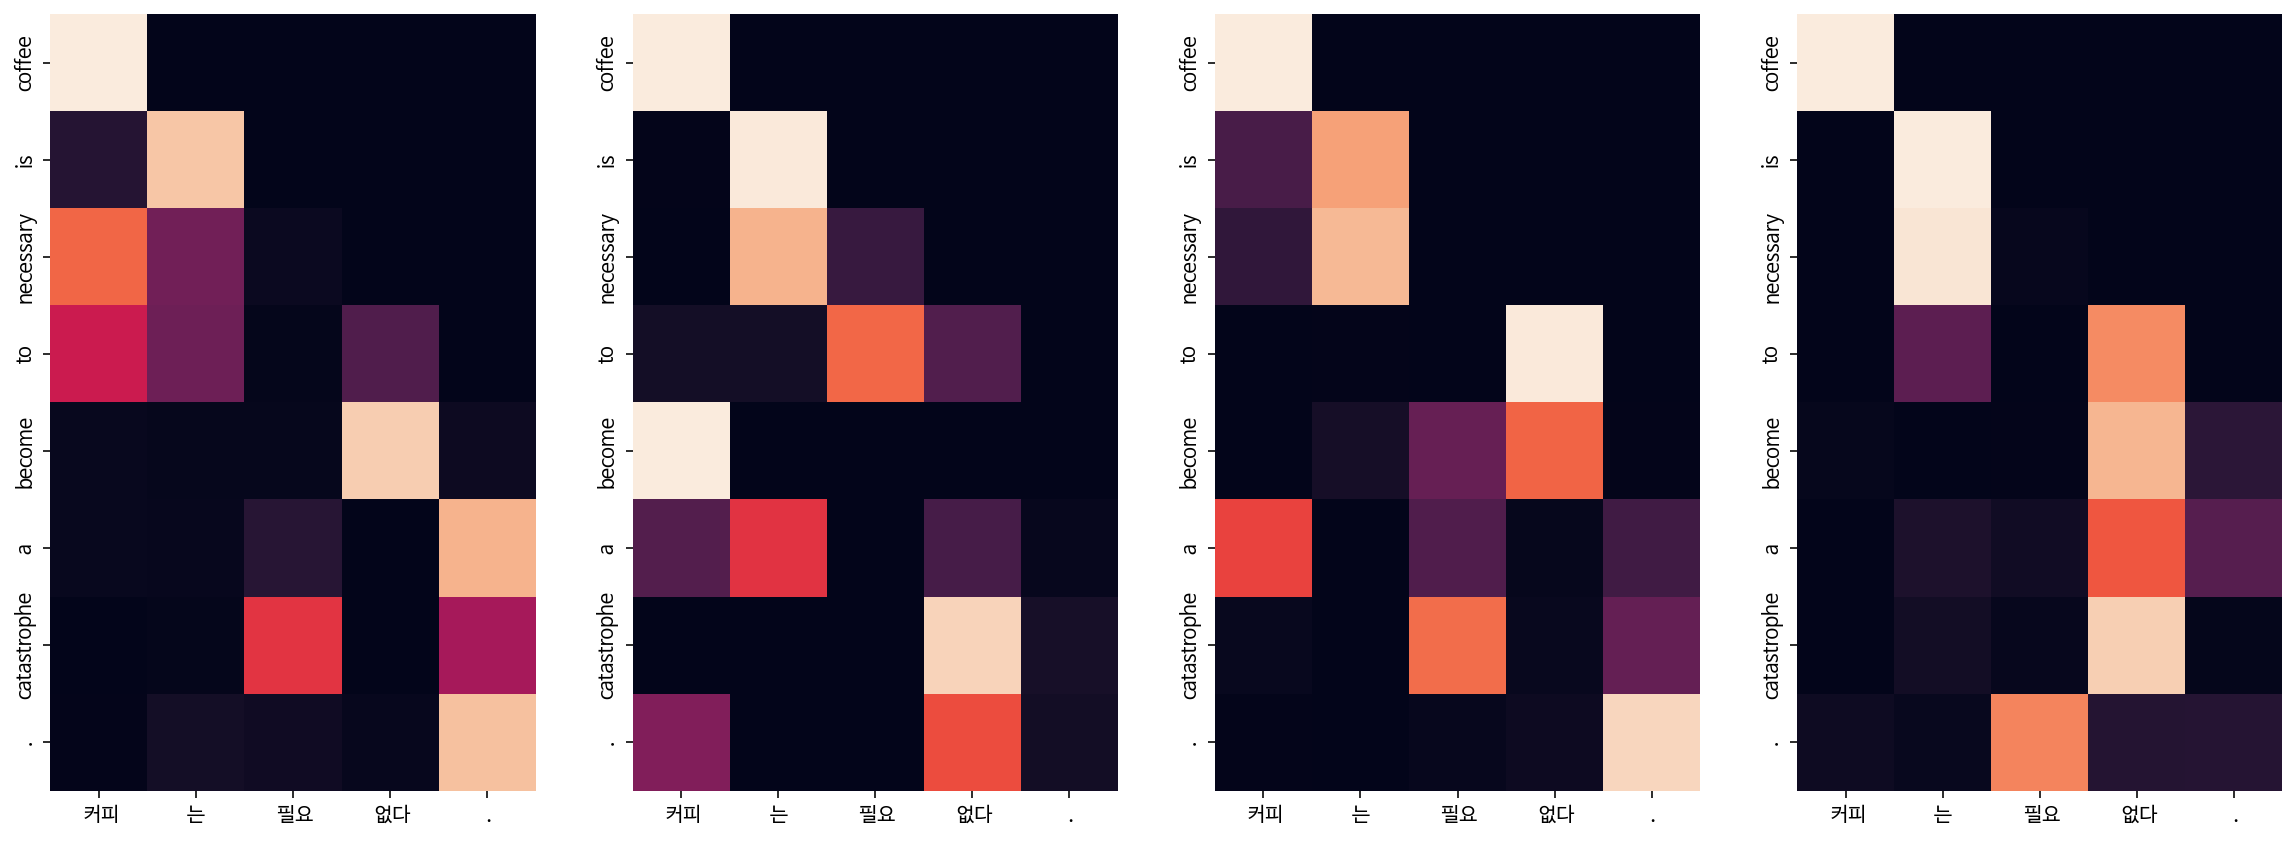

Decoder Self Layer 2


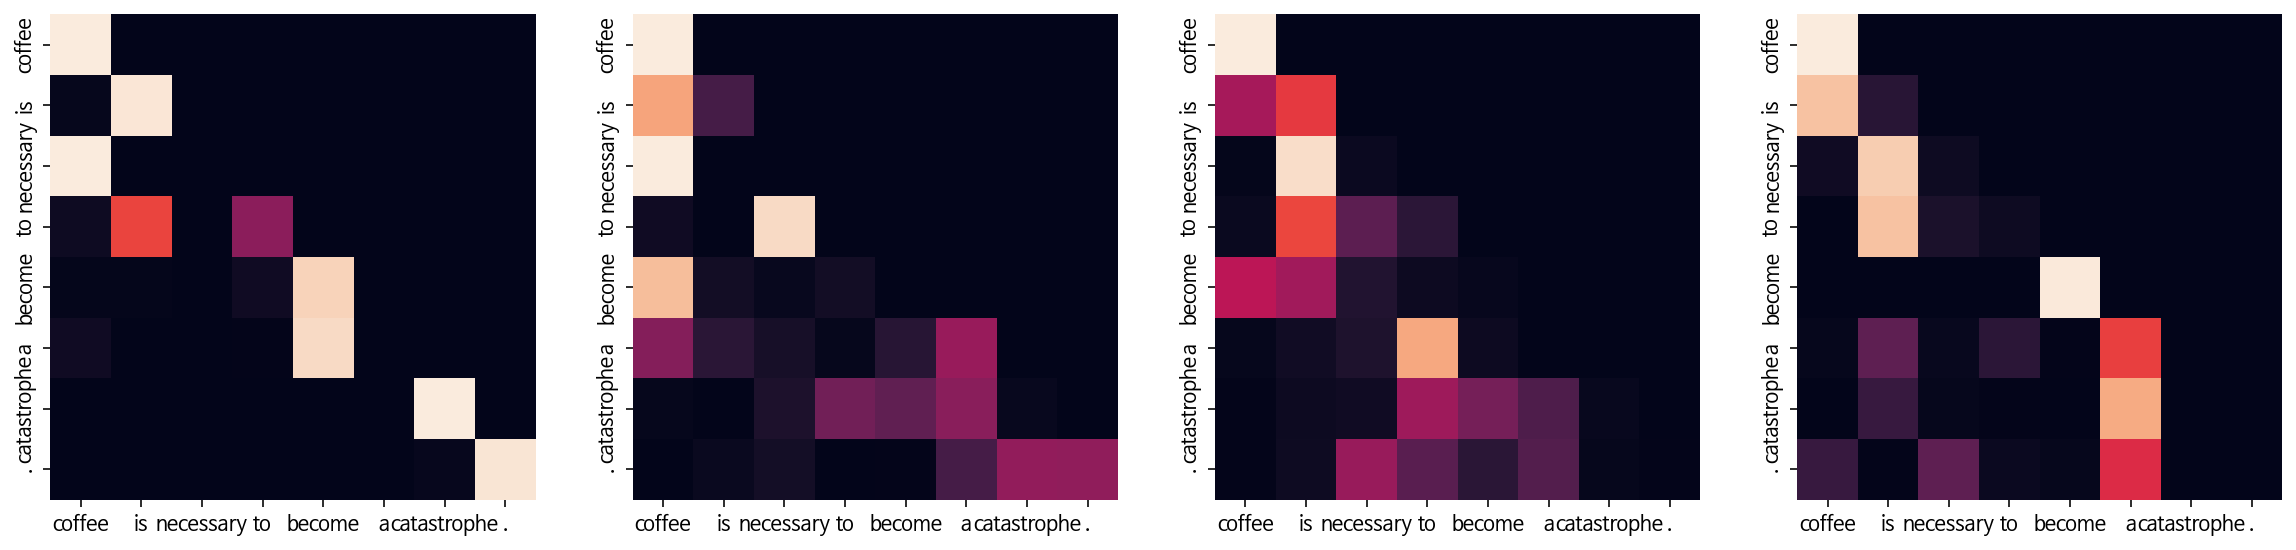

Decoder Src Layer 2


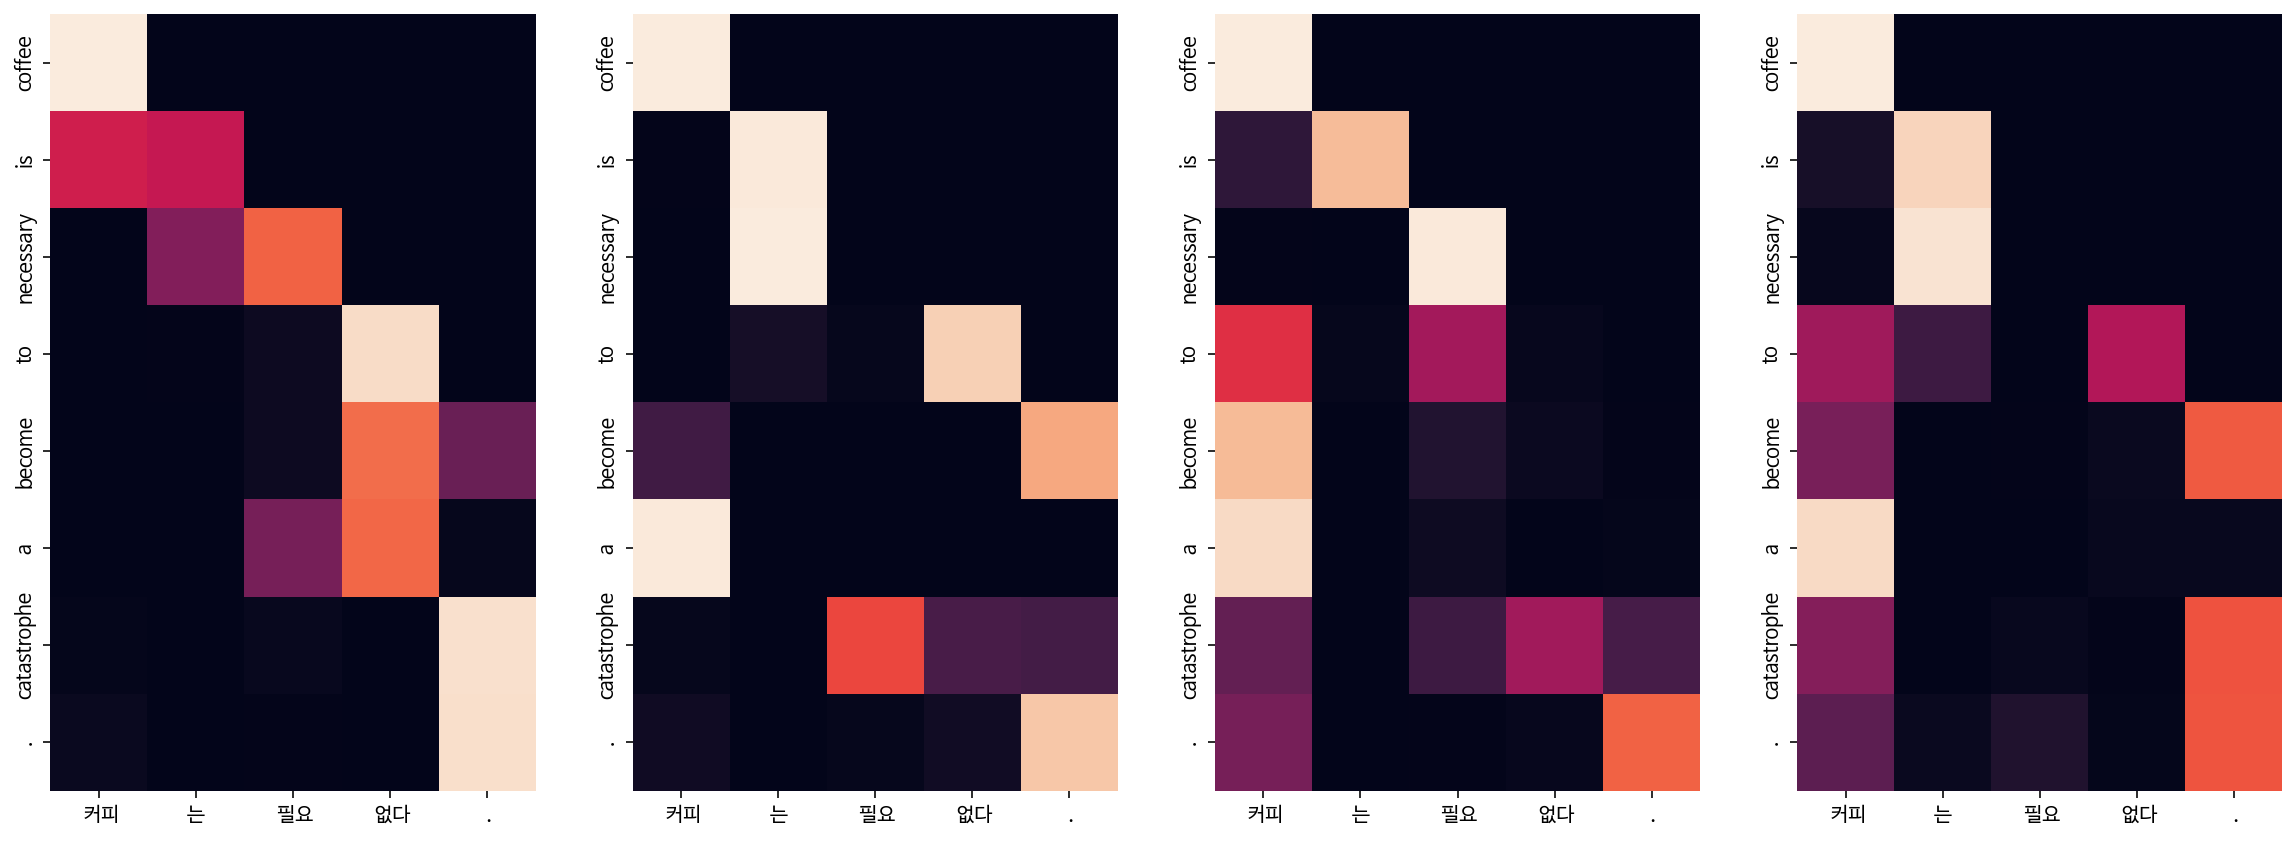

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on thursday , seven seven people were killed .
Encoder Layer 1


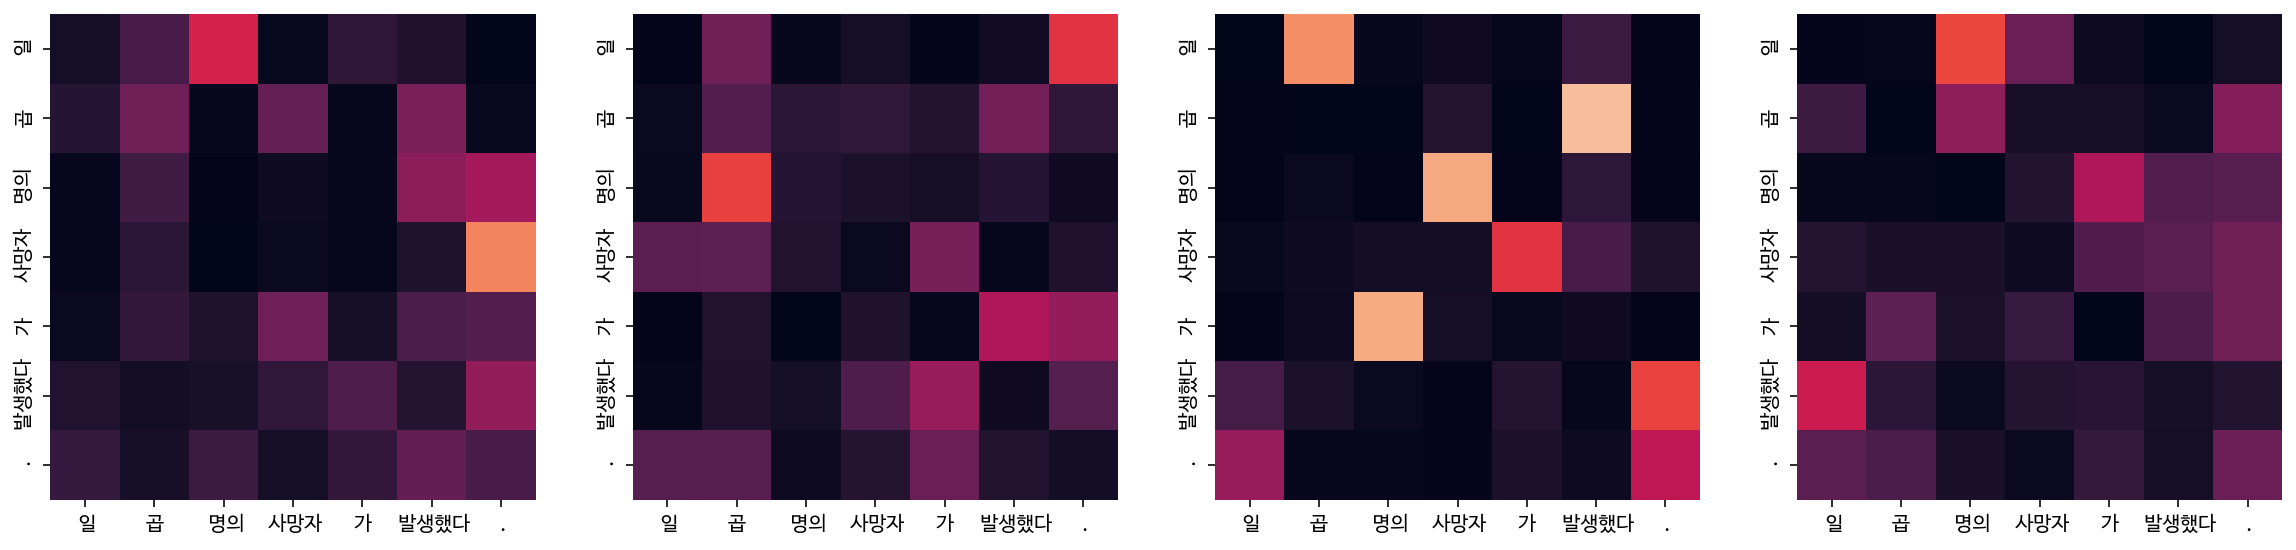

Encoder Layer 2


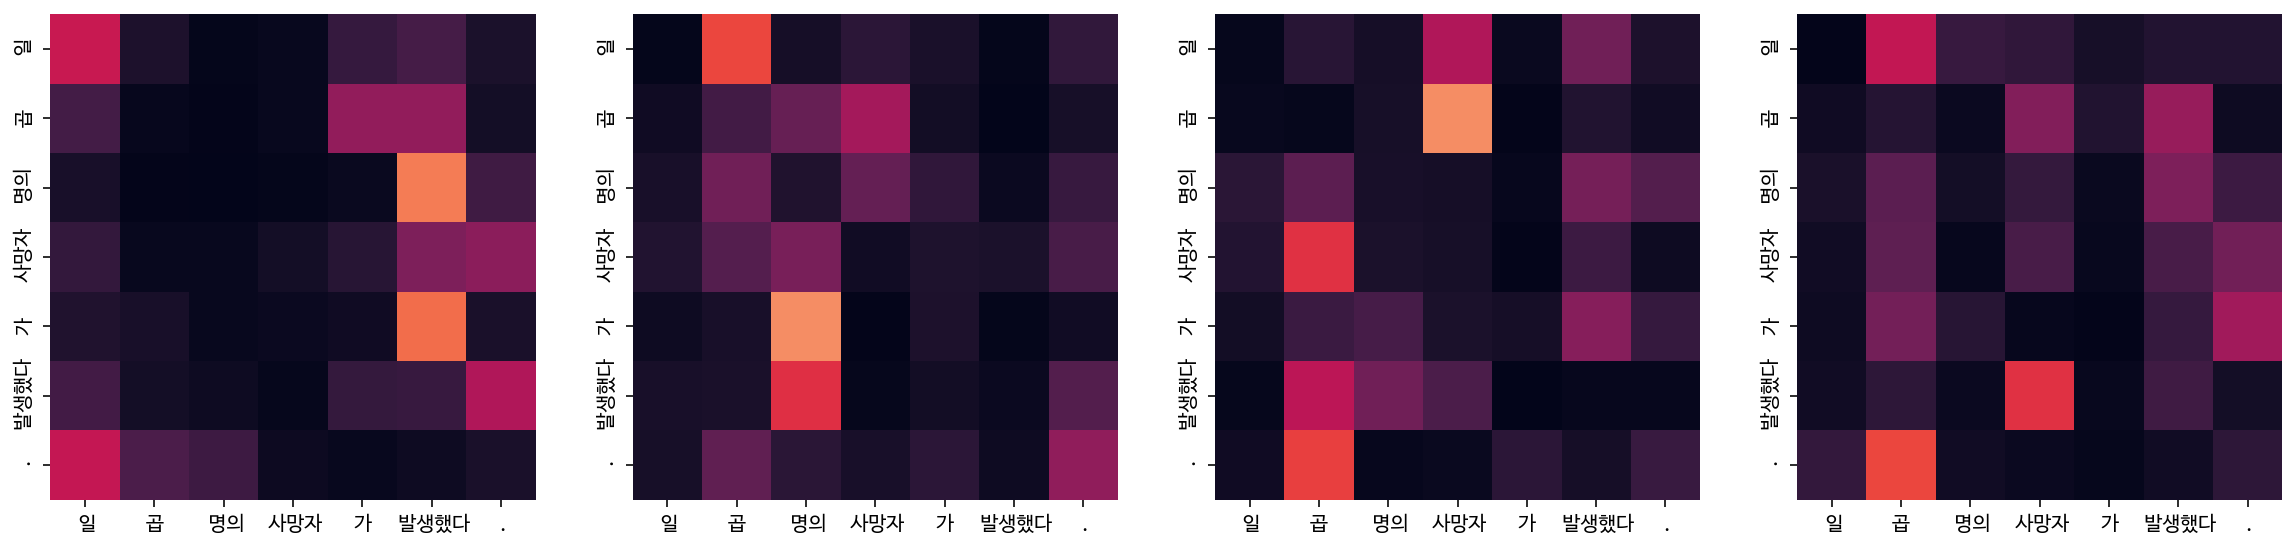

Decoder Self Layer 1


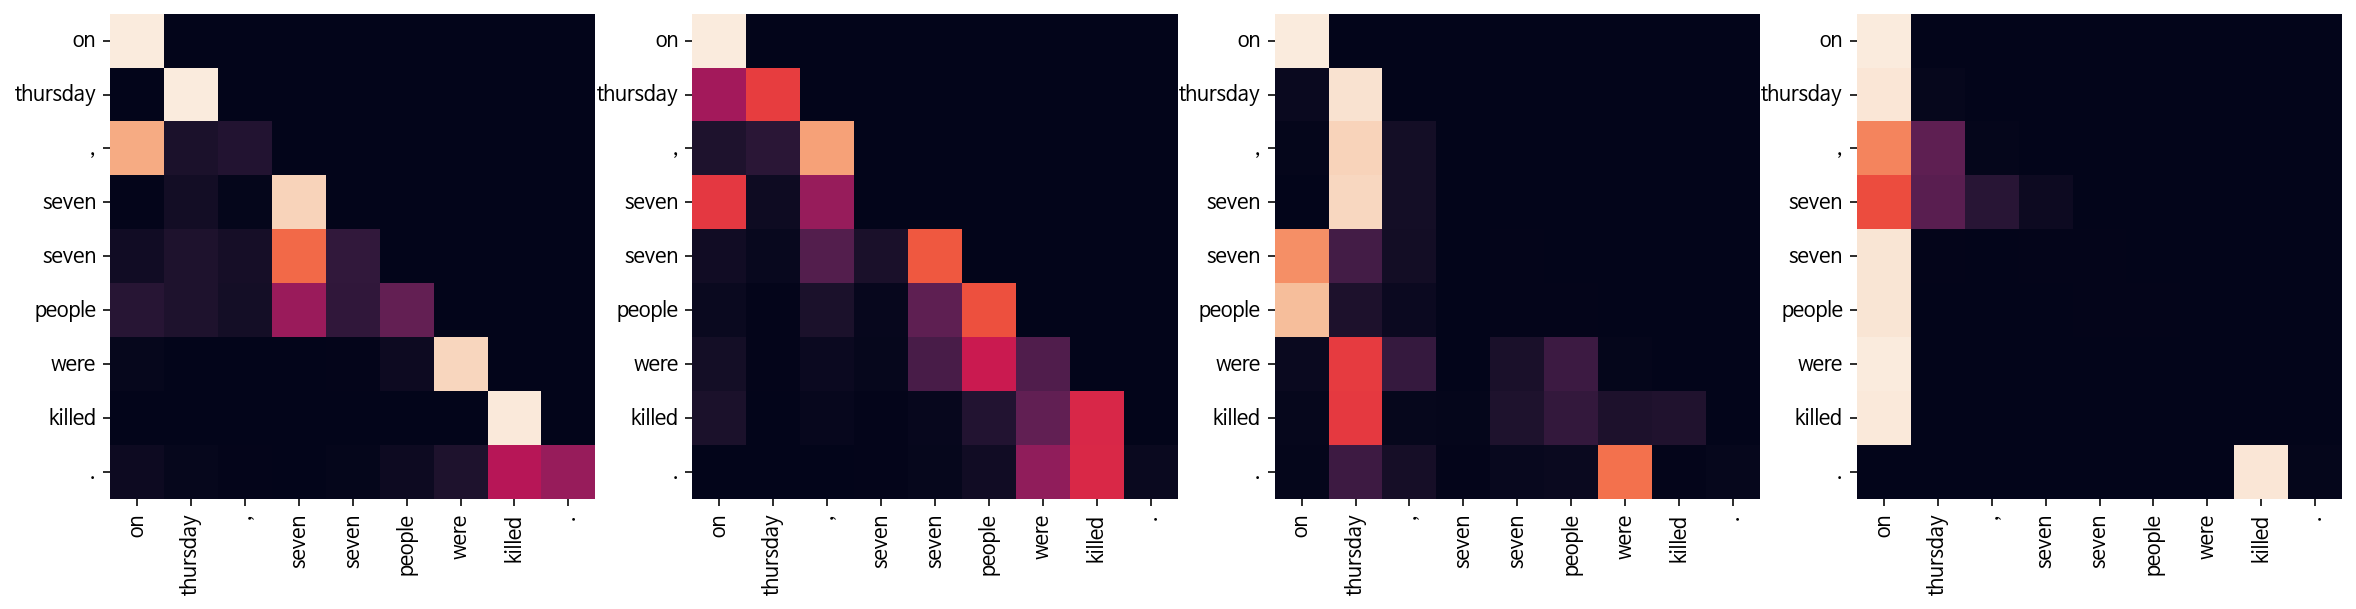

Decoder Src Layer 1


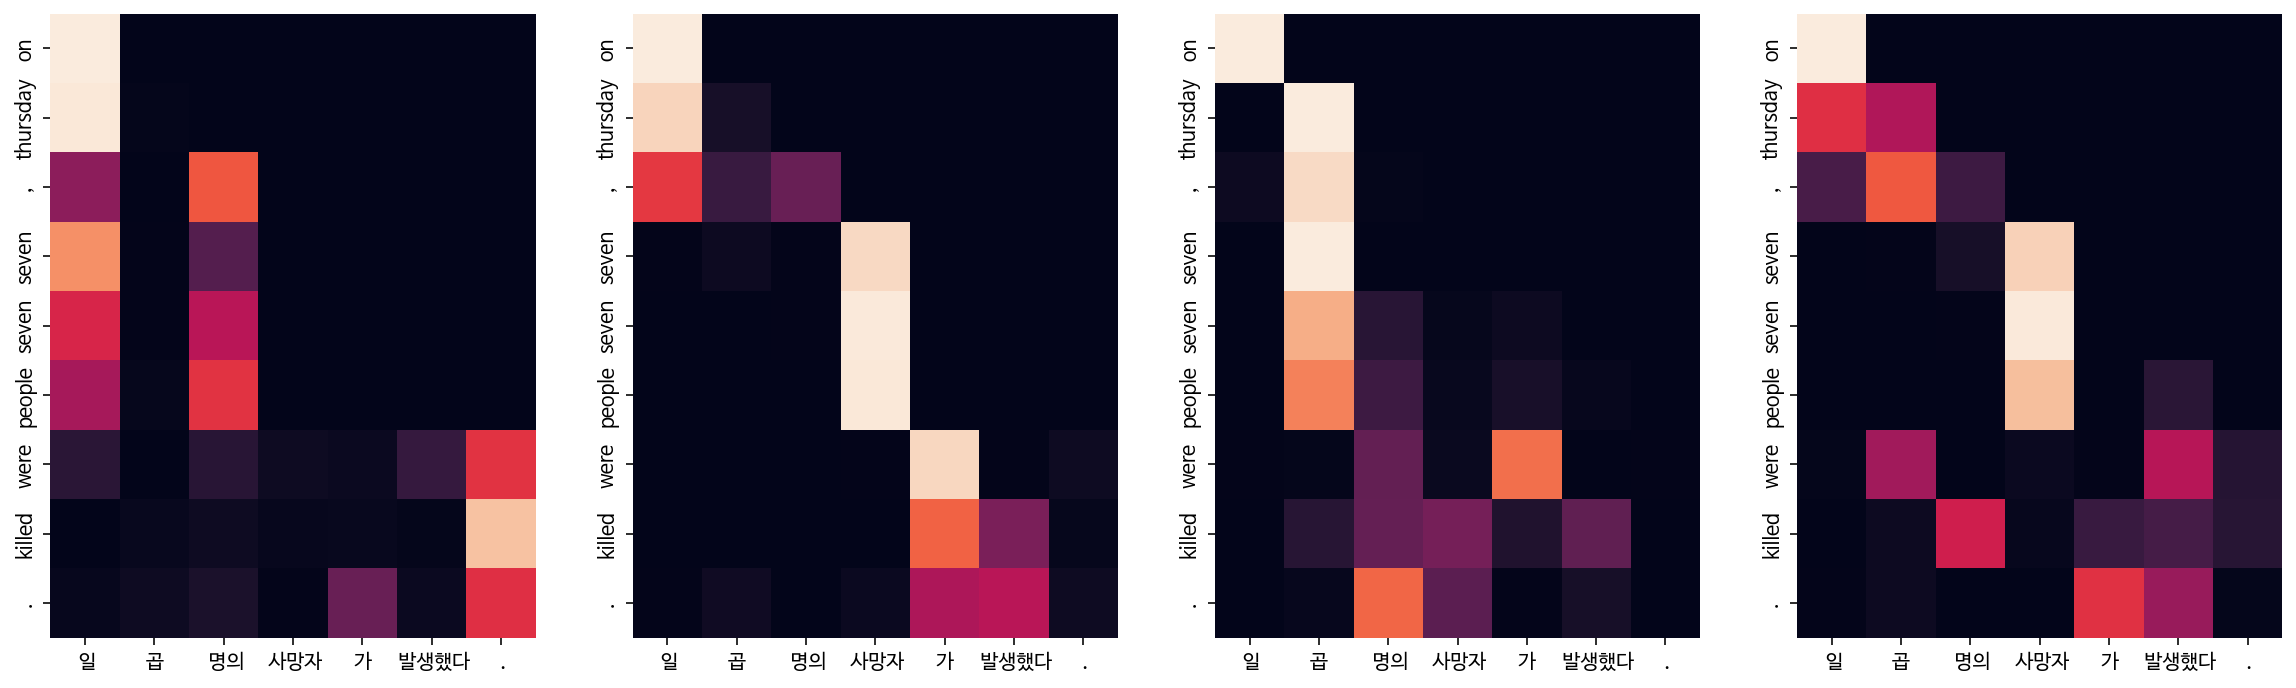

Decoder Self Layer 2


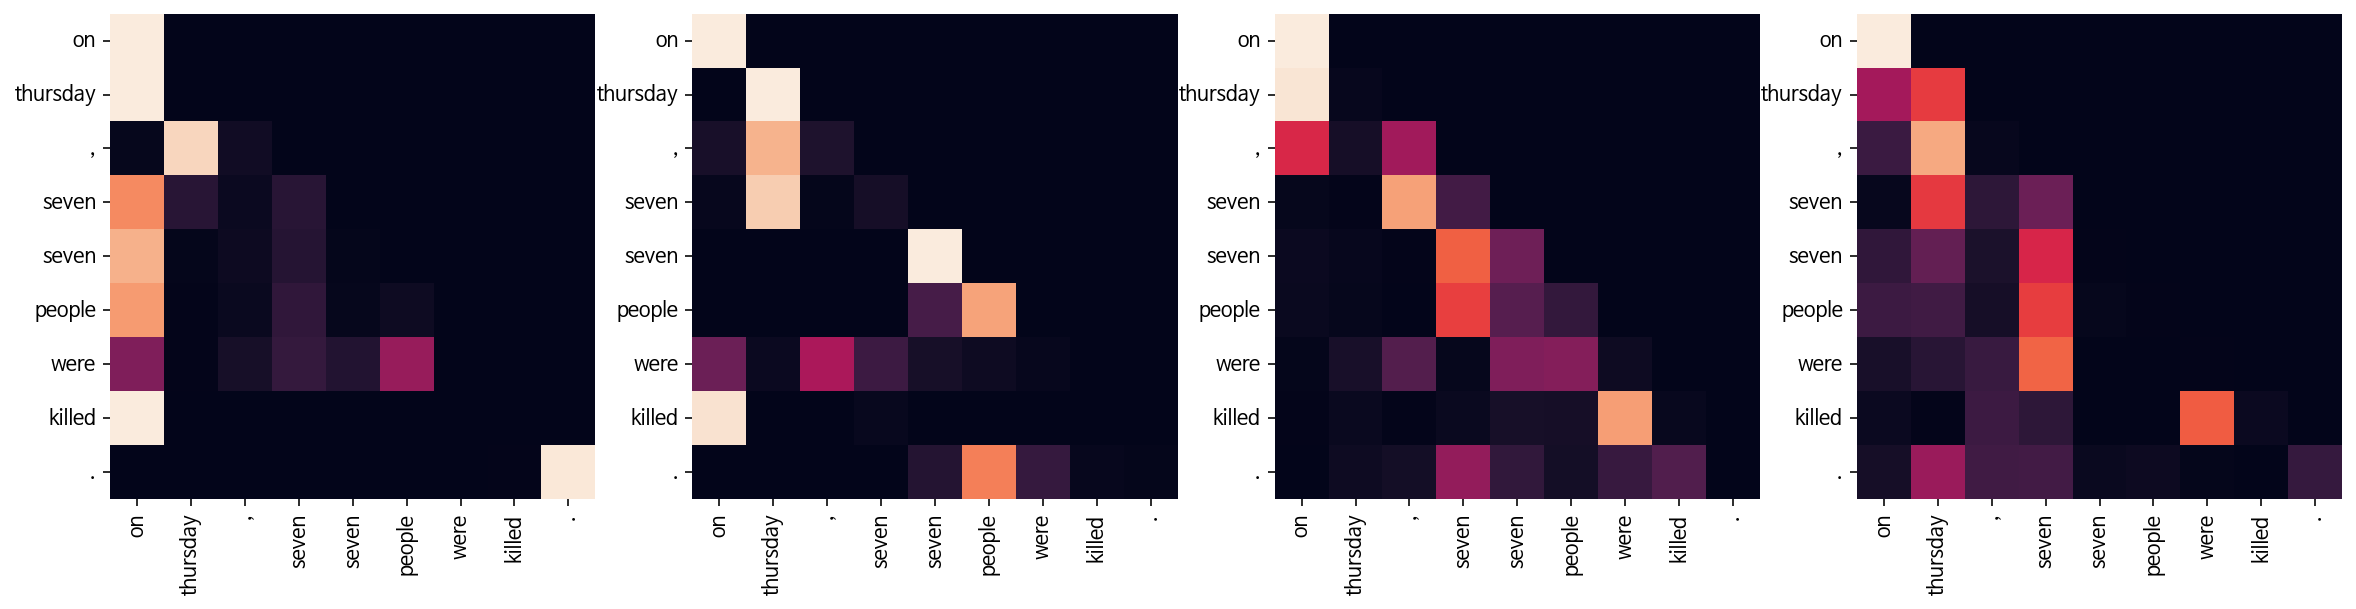

Decoder Src Layer 2


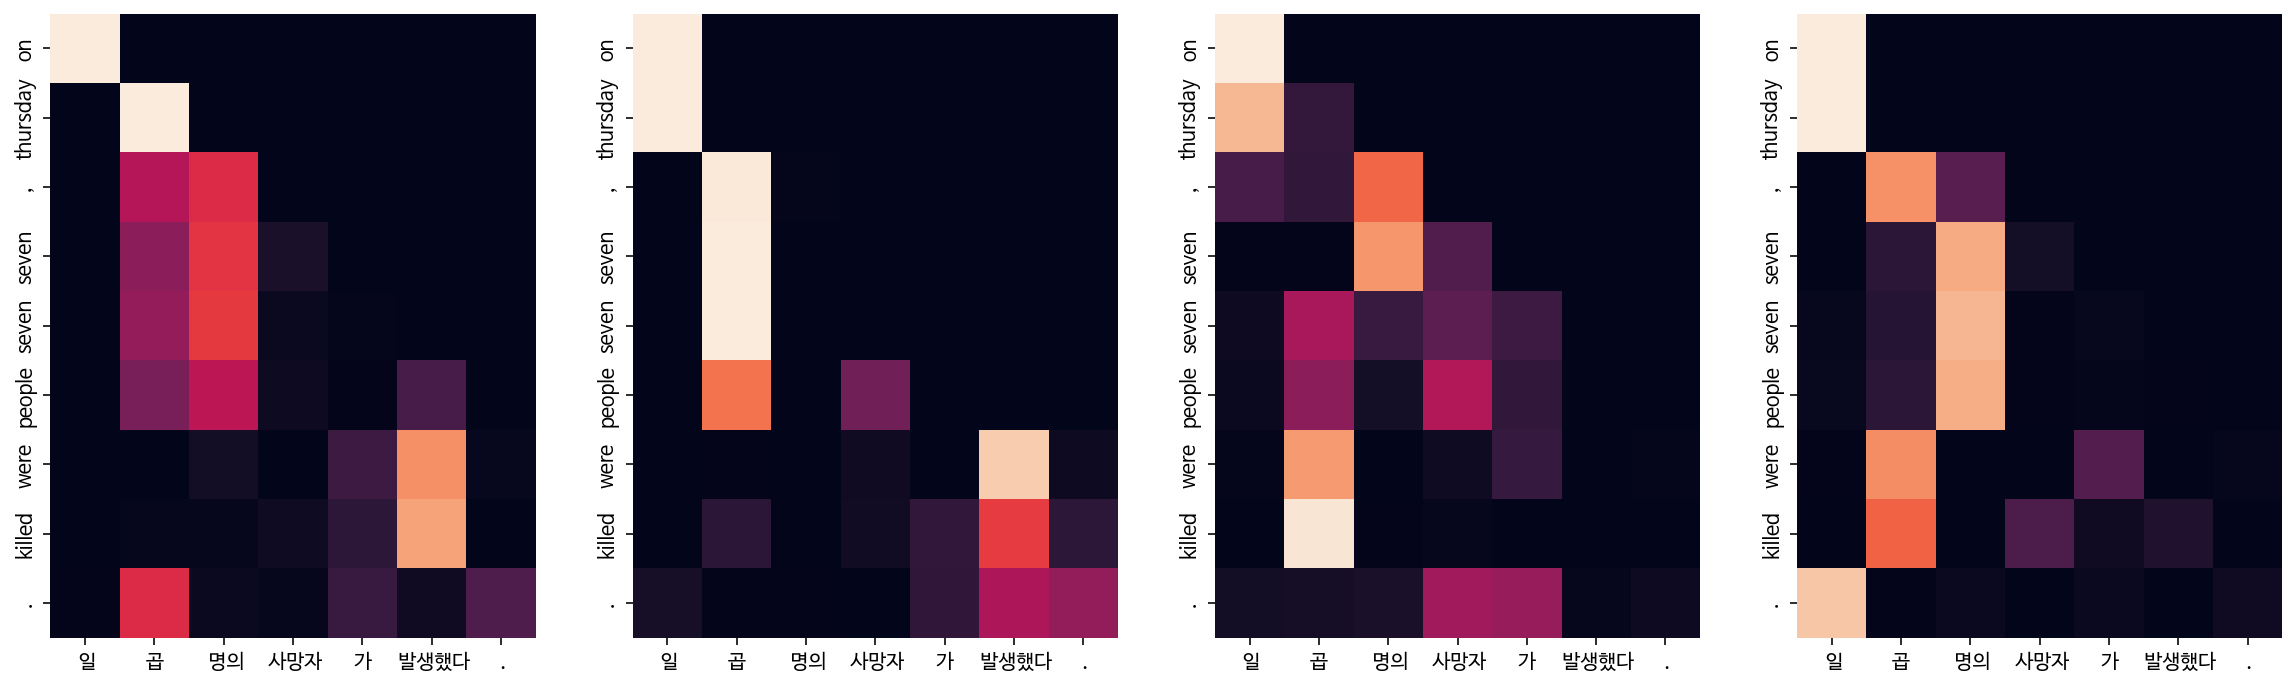

In [36]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

## 결론

### 루브릭

|평가문항|상세기준|
|:---|:---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

### 고찰

Loss 0.1486의 20 epoch 결과를 기준으로 **네이버 파파고 번역기**, 이전 프로젝트에서 진행했던 **Seq2Seq** 모델 결과와 비교해보았다.


`input` **오바마**는 **대통령**이다.  
`predict` **obama** is a **presidential candidate** from illinois.  
`seq2seq` **obam** is the **president** elect.  
`papago` obama is the president.  

> seq2seq 모델 프로젝트에서 가장 잘 번역했던 문장이었다. transformer 모델에서도 그럴듯한 번역이 완성된 것 같다. Loss 2.8287 5 epoch에서 `obama is a president.` 라는 더 정답에 가까운 문장이 나왔는데, 자연어 처리 모델의 성능 지표에 대해 더 알아봐야 할 것 같다.  


`input` 시민들은 **도시** 속에 산다.    
`predict` instead of plymouth, they actively looked over our torches in the **cities**.  <br>
`seq2seq` the people are not uncommon in the **city**.  <br>
`papago` citizens live in cities.  
> 두 모델 모두 이 문장의 번역을 어려워했다. `city`라는 단어 자체는 들어갔지만 문장의 의미가 맞지 않았다.

`input` **커피**는 **필요 없다**.  <Br>
`predict` there's **no need** for **coffee** at coffee.  
`seq2seq` the \<unk> is not a lot of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of the \<unk> of    
`papago` I don't need coffee.  
> seq2seq 모델은 이 문장을 번역하지 못했지만 transformer 모델은 그럴듯한 결과를 내놓았다. 의미적으로 완벽히 동일하지는 않지만, `no need`, `coffee` 라는 핵심적인 의미가 반영되었다.

`input` **일곱 명**의 **사망자**가 발생했다.  
`predict` **seven people** were **killed**, seven others were wounded thursday, she said.  
`seq2seq` two of the two people were **killed**. <br> 
`papago` Seven people were killed.
> seq2seq 모델은 `killed`라는 단어만 성공적으로 보여주었지만 transformer 모델은 입력 문장을 모두 반영하였다. 그러나 뒤쪽에 `seven others were wounded thursday, she said.`라는 부분이 추가되었다. 8 epoch의 결과에서는 추가된 문장 없이 `seven people were killed.`만 출력하였다.
    
    
전반적으로 seq2seq 모델보다는 좋은 결과물을 보여주었다. 

### 회고

|KPT|내용|
|:---|:---|
|Keep|모델을 완성하고 주어진 과제를 평가 기준에 맞춰 수행하였다.|
|Problem|모델 훈련에 생각보다 많은 시간이 걸려서 다양한 조건 아래에서 실험하지 못했다.|
|Try|트랜스포머 모델에 대해 더 알아보고 이해하는 과정을 거친 후 하이퍼 파라미터를 조정해 결과가 어떻게 변하는지 알아본다.|
